# Advanced Vector Autoregression (VAR) Analysis of Luxury Brand Equity Prices

## Overview
This notebook performs a comprehensive time series econometric analysis of luxury brand stock prices including:
- **Prada (1913.HK)** - Hong Kong listed
- **LVMH (MC.PA)** - Moët Hennessy Louis Vuitton
- **Kering (KER.PA)** - Gucci, Saint Laurent, Bottega Veneta
- **Hermès (RMS.PA)** - French luxury manufacturer
- **Richemont (CFR.SW)** - Cartier, Van Cleef & Arpels
- **Burberry (BRBY.L)** - British luxury fashion house

## Advanced Analyses Included
1. Data extraction and preprocessing
2. Stationarity testing (ADF test)
3. Optimal lag selection (MAIC, MSBIC, MHQIC)
4. **Standard VAR model estimation**
5. **Granger causality testing (time-domain & frequency-domain)**
6. **Bayesian VAR (BVAR) with Minnesota priors**
7. Impulse Response Functions (IRF)
8. Variance Decomposition (FEVD)
9. **State-Space VAR with Kalman Filter**
10. **Non-linear VAR: Threshold VAR (TVAR)**
11. **Markov-Switching VAR (MS-VAR)**

## 1. Setup and Installation

First, we'll install the necessary packages and import required libraries.

In [ ]:
!pip install statsmodels pandas numpy matplotlib seaborn scipy scikit-learn arch -q

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.statespace.varmax import VARMAX
from scipy import signal, stats
from scipy.linalg import cho_solve, cho_factor
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. Data Loading and Extraction

We'll load the CSV file and filter data for the six luxury brands we're analyzing.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/fashion_luxury_equity_data.csv', delimiter= ',')
print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst few rows:")
df.head()

Dataset shape: (75131, 4)

Columns: ['Date', 'Close', 'Volume', 'Ticker']

First few rows:


Date       Close    Volume Ticker
0  2022-09-30  576.937622  477030.0  MC.PA
1  2022-10-03  574.669128  391198.0  MC.PA
2  2022-10-04  611.342102  574934.0  MC.PA
3  2022-10-05  602.362854  386410.0  MC.PA
4  2022-10-06  600.283447  227173.0  MC.PA

In [ ]:
luxury_brands = {
    '1913.HK': 'Prada',
    'MC.PA': 'LVMH',
    'KER.PA': 'Kering',
    'RMS.PA': 'Hermes',
}
df_luxury = df[df['Ticker'].isin(luxury_brands.keys())]
print(f"Filtered dataset shape: {df_luxury.shape}")
print(f"\nAvailable tickers and their counts:")
print(df_luxury['Ticker'].value_counts())
print(f"\nDate range: {df_luxury['Date'].min()} to {df_luxury['Date'].max()}")

Filtered dataset shape: (3030, 4)

Available tickers and their counts:
Ticker
MC.PA      765
KER.PA     765
RMS.PA     765
1913.HK    735
Name: count, dtype: int64

Date range: 2022-09-30 to 2025-09-26


## 3. Data Preprocessing - Creating Pivot Table

We'll transform the data into a pivot table where:
- **Rows**: Dates (time index)
- **Columns**: Brand names
- **Values**: Historical closing prices

In [ ]:
df_luxury['Date'] = pd.to_datetime(df_luxury['Date'])
df_luxury['Brand'] = df_luxury['Ticker'].map(luxury_brands)

price_pivot = df_luxury.pivot_table(
    index='Date',
    columns='Brand',
    values='Close',
    aggfunc='first'
).sort_index()

price_pivot = price_pivot.fillna(price_pivot.rolling(window=5, min_periods=1).mean())

print(f"Pivot table shape: {price_pivot.shape}")
print(f"\nDate range after preprocessing: {price_pivot.index.min()} to {price_pivot.index.max()}")
print(f"\nNumber of observations: {len(price_pivot)}")
print(f"\nBrands (columns): {price_pivot.columns.tolist()}")
print("\nFirst few rows:")
price_pivot.head(10)

Pivot table shape: (765, 4)

Date range after preprocessing: 2022-09-30 00:00:00 to 2025-09-26 00:00:00

Number of observations: 765

Brands (columns): ['Hermes', 'Kering', 'LVMH', 'Prada']

First few rows:


Brand            Hermes      Kering        LVMH      Prada
Date                                                      
2022-09-30  1193.137085  416.233002  576.937622  34.130188
2022-10-03  1203.921509  412.829071  574.669128  34.411480
2022-10-04  1277.450928  436.157379  611.342102  34.270834
2022-10-05  1271.078247  421.724731  602.362854  37.927639
2022-10-06  1271.568481  413.918365  600.283447  37.833874
2022-10-07  1240.195923  408.018188  584.309998  37.458817
2022-10-10  1224.019531  402.617279  577.032043  36.052353
2022-10-11  1236.274292  404.160370  577.032043  34.739655
2022-10-12  1258.823364  404.341919  587.807190  33.239426
2022-10-13  1229.901733  402.299591  583.648376  33.567600

In [ ]:
print("\nDescriptive Statistics:")
price_pivot.describe()


Descriptive Statistics:


Brand       Hermes      Kering        LVMH       Prada
count   765.000000  765.000000  765.000000  765.000000
mean   2020.074007  343.136552  669.606605   50.396084
std     325.347550  115.740904  107.936325    7.184196
min    1193.137085  153.521988  437.549988   32.817486
25%    1831.506592  231.913544  601.039612   44.641815
50%    2021.136108  337.832367  675.396484   50.883095
75%    2270.548828  456.342255  763.114502   55.303268
max    2821.044922  549.013000  858.372986   68.352898

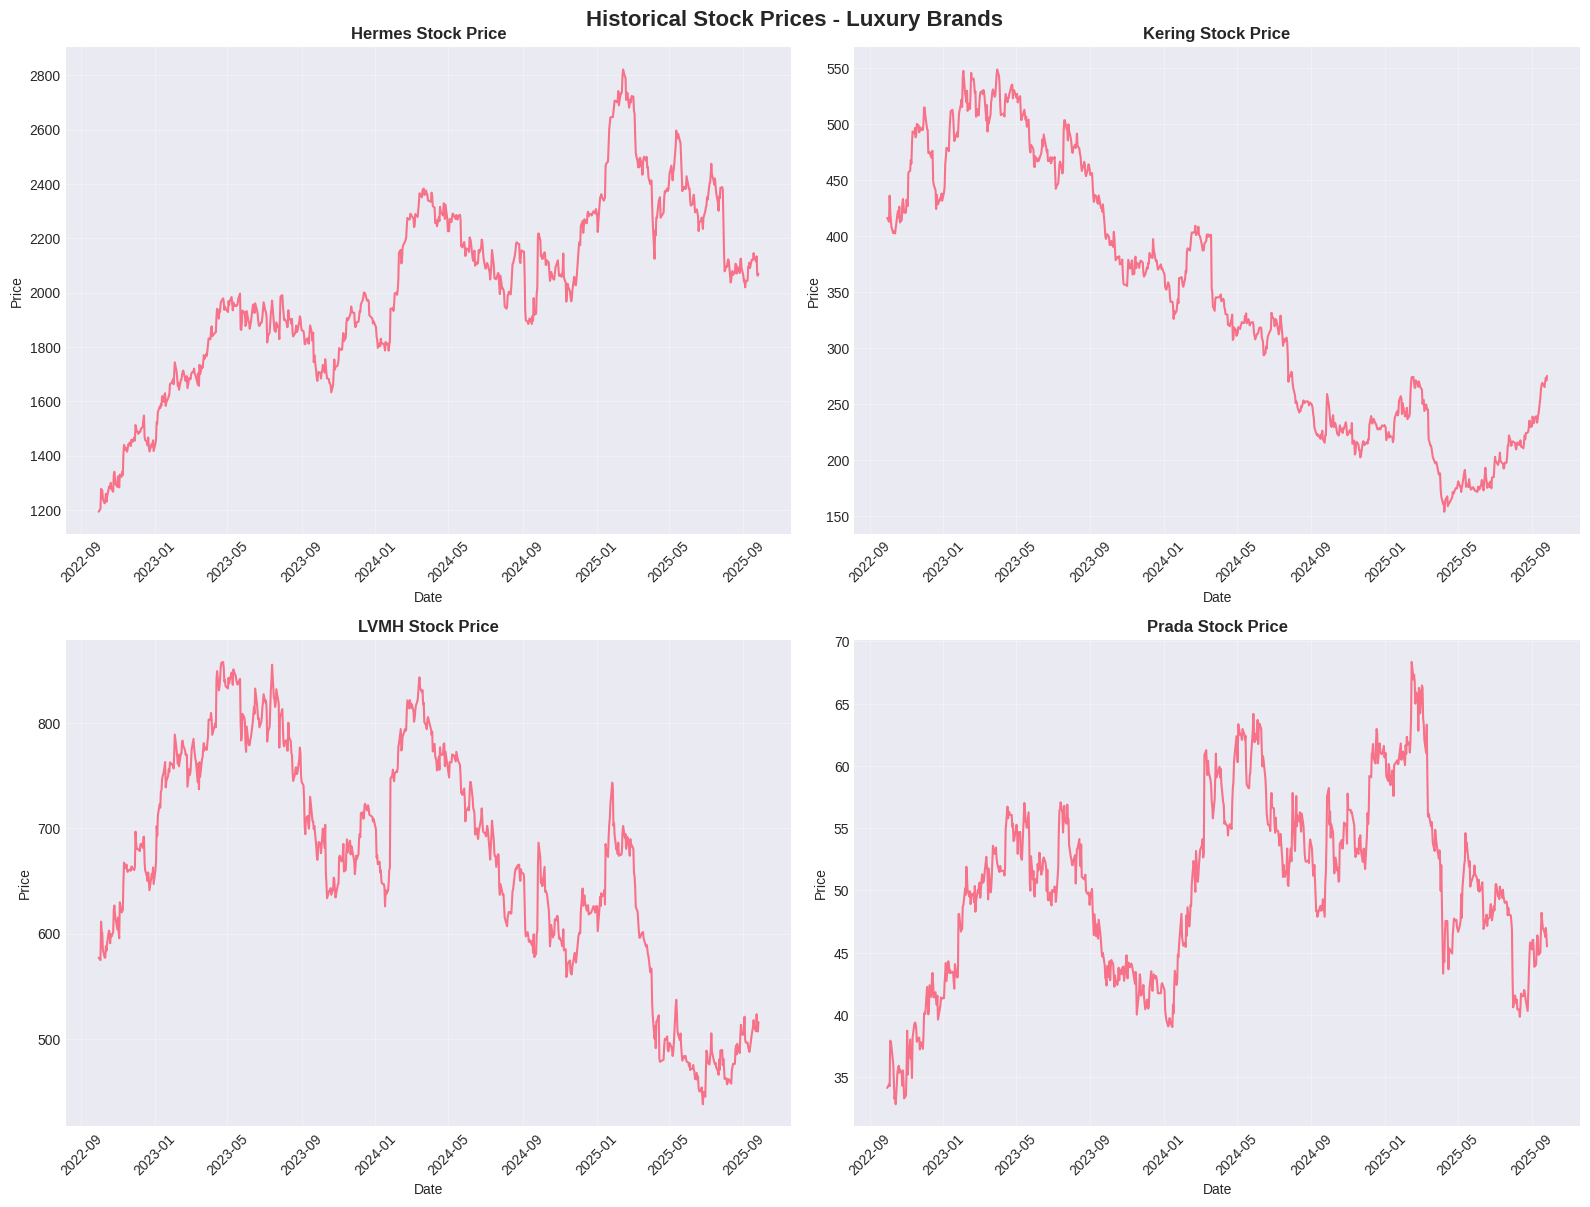

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, brand in enumerate(price_pivot.columns):
    axes[idx].plot(price_pivot.index, price_pivot[brand], linewidth=1.5)
    axes[idx].set_title(f'{brand} Stock Price', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Price')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.suptitle('Historical Stock Prices - Luxury Brands', fontsize=16, fontweight='bold', y=1.002)
plt.show()

## 4. Stationarity Testing - Augmented Dickey-Fuller (ADF) Test

The ADF test checks whether each time series is stationary. For VAR models, we need stationary data.

**Null Hypothesis (H₀)**: The series has a unit root (non-stationary)

**Alternative Hypothesis (H₁)**: The series is stationary

If **p-value < 0.05**, we reject H₀ and conclude the series is stationary.

In [ ]:
def adf_test(series, name=''):
    """
    Perform Augmented Dickey-Fuller test
    """
    result = adfuller(series.dropna(), autolag='AIC')

    return {
        'Brand': name,
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Used Lag': result[2],
        'Observations': result[3],
        'Critical Value (1%)': result[4]['1%'],
        'Critical Value (5%)': result[4]['5%'],
        'Critical Value (10%)': result[4]['10%'],
        'Stationary': 'Yes' if result[1] < 0.05 else 'No'
    }

adf_results = []
for brand in price_pivot.columns:
    result = adf_test(price_pivot[brand], name=brand)
    adf_results.append(result)

adf_df = pd.DataFrame(adf_results)
print("\n" + "="*100)
print("ADF TEST RESULTS - PRICE LEVELS")
print("="*100)
print(adf_df.to_string(index=False))
print("\n" + "="*100)


ADF TEST RESULTS - PRICE LEVELS
 Brand  ADF Statistic  p-value  Used Lag  Observations  Critical Value (1%)  Critical Value (5%)  Critical Value (10%) Stationary
Hermes      -2.378397 0.147927         3           761            -3.438972            -2.865345             -2.568796         No
Kering      -0.872244 0.796975         0           764            -3.438938            -2.865330             -2.568788         No
  LVMH      -1.308506 0.625272         0           764            -3.438938            -2.865330             -2.568788         No
 Prada      -2.666261 0.080061         2           762            -3.438961            -2.865340             -2.568794         No



### 4.1 First Differencing

If the price levels are non-stationary, we'll apply first differencing to make them stationary.

**First Difference**: Δy_t = y_t - y_{t-1} (returns)

In [ ]:
price_diff = price_pivot.diff().dropna()

print(f"Differenced data shape: {price_diff.shape}")
print("\nFirst few rows of differenced data:")
price_diff.head()

Differenced data shape: (764, 4)

First few rows of differenced data:


Brand          Hermes     Kering       LVMH     Prada
Date                                                 
2022-10-03  10.784424  -3.403931  -2.268494  0.281292
2022-10-04  73.529419  23.328308  36.672974 -0.140646
2022-10-05  -6.372681 -14.432648  -8.979248  3.656805
2022-10-06   0.490234  -7.806366  -2.079407 -0.093765
2022-10-07 -31.372559  -5.900177 -15.973450 -0.375057

In [ ]:
adf_diff_results = []
for brand in price_diff.columns:
    result = adf_test(price_diff[brand], name=brand)
    adf_diff_results.append(result)

adf_diff_df = pd.DataFrame(adf_diff_results)
print("\n" + "="*100)
print("ADF TEST RESULTS - FIRST DIFFERENCES (RETURNS)")
print("="*100)
print(adf_diff_df.to_string(index=False))
print("\n" + "="*100)


ADF TEST RESULTS - FIRST DIFFERENCES (RETURNS)
 Brand  ADF Statistic      p-value  Used Lag  Observations  Critical Value (1%)  Critical Value (5%)  Critical Value (10%) Stationary
Hermes     -16.778489 1.269903e-29         2           761            -3.438972            -2.865345             -2.568796        Yes
Kering     -27.122473 0.000000e+00         0           763            -3.438950            -2.865335             -2.568791        Yes
  LVMH     -28.599215 0.000000e+00         0           763            -3.438950            -2.865335             -2.568791        Yes
 Prada     -22.033816 0.000000e+00         1           762            -3.438961            -2.865340             -2.568794        Yes



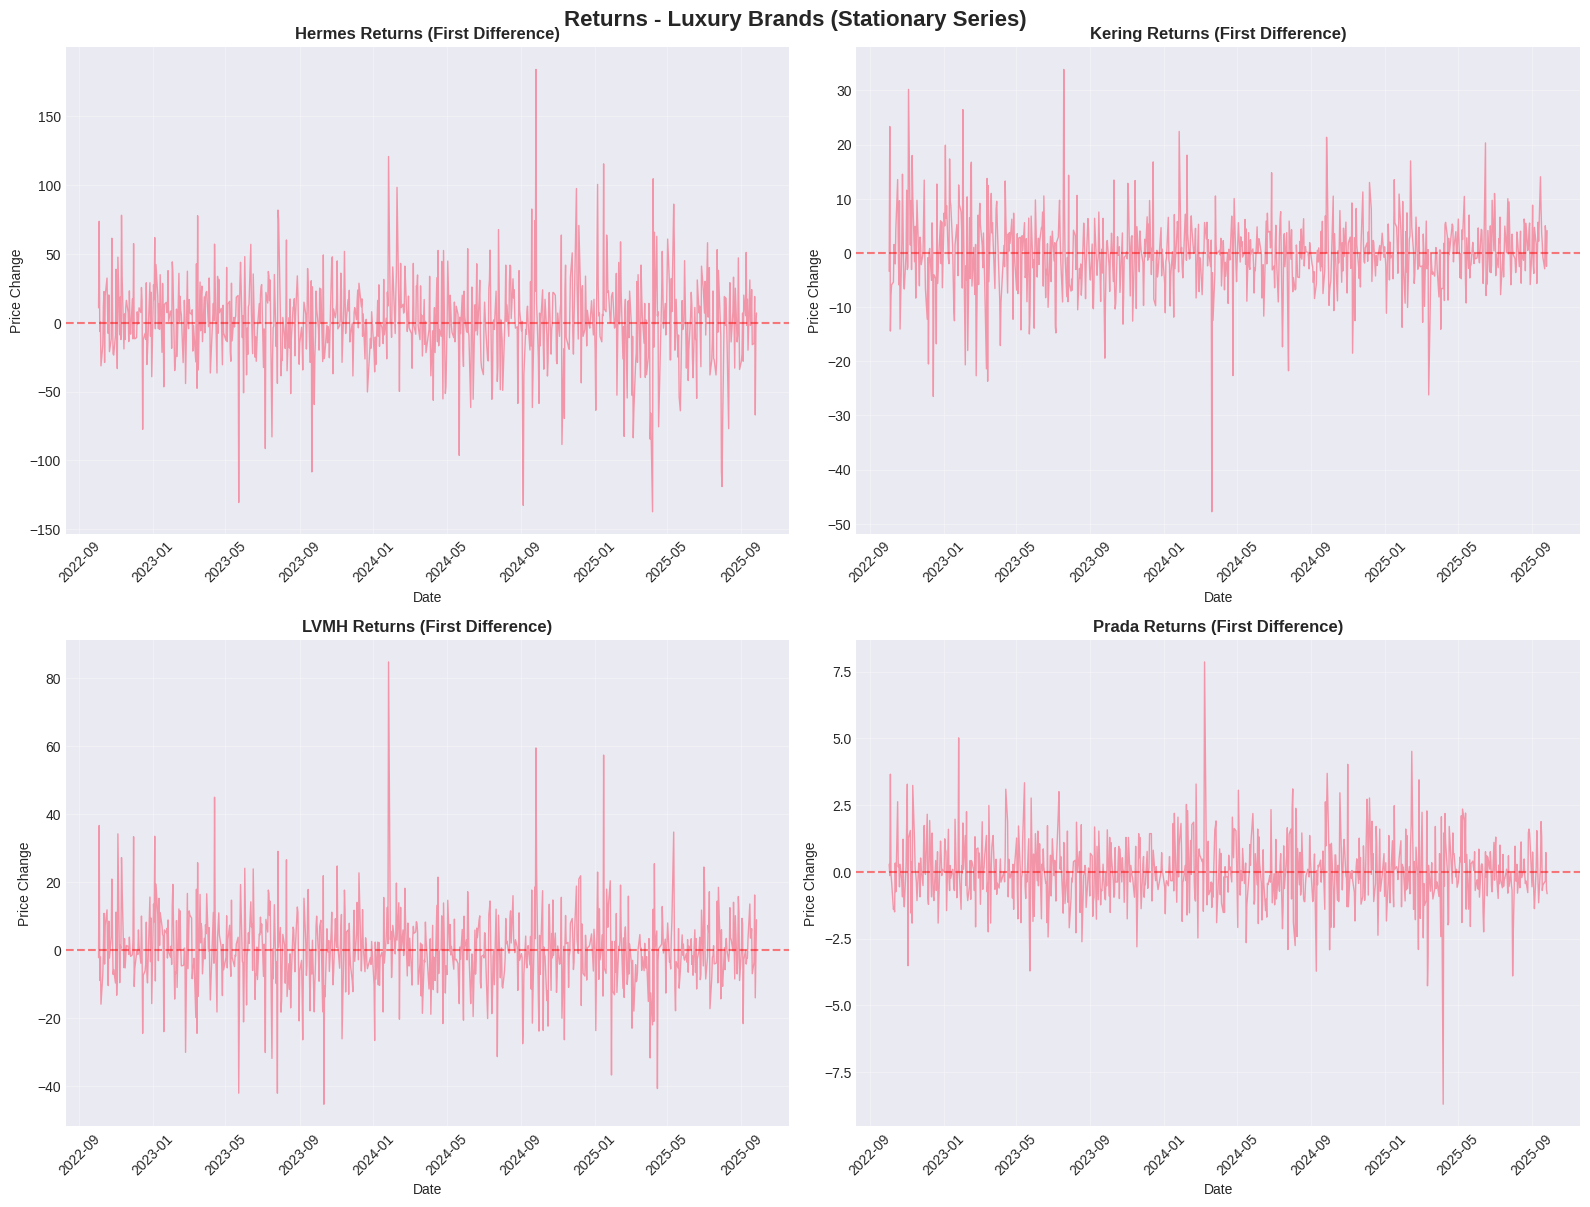

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, brand in enumerate(price_diff.columns):
    axes[idx].plot(price_diff.index, price_diff[brand], linewidth=1, alpha=0.7)
    axes[idx].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    axes[idx].set_title(f'{brand} Returns (First Difference)', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Price Change')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.suptitle('Returns - Luxury Brands (Stationary Series)', fontsize=16, fontweight='bold', y=1.002)
plt.show()

### 4.2 Select Appropriate Data for VAR

Based on ADF test results, we'll use the stationary series for VAR modeling.

In [ ]:
if adf_diff_df['Stationary'].eq('Yes').all():
    var_data = price_diff.copy()
    print("✓ Using first-differenced data (all series are stationary)")
else:
    var_data = price_pivot.copy()
    print("⚠ Using price levels (some differenced series may not be stationary)")

print(f"\nVAR data shape: {var_data.shape}")
print(f"Date range: {var_data.index.min()} to {var_data.index.max()}")

✓ Using first-differenced data (all series are stationary)

VAR data shape: (764, 4)
Date range: 2022-10-03 00:00:00 to 2025-09-26 00:00:00


### 4.3 Correlation Analysis

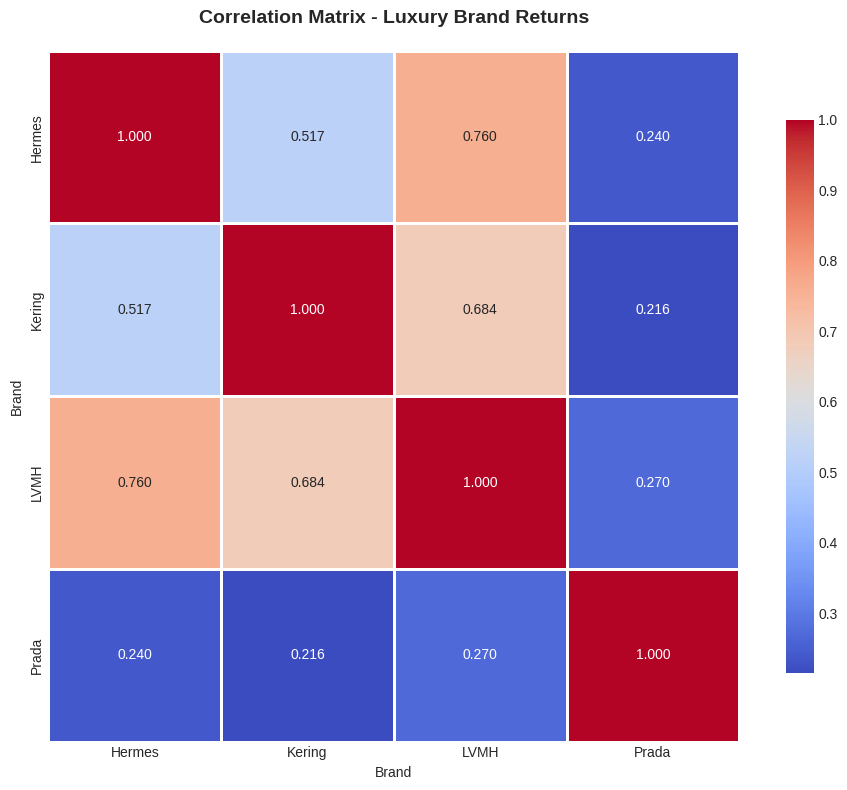


Correlation Matrix:
Brand     Hermes    Kering      LVMH     Prada
Brand                                         
Hermes  1.000000  0.516626  0.760141  0.239560
Kering  0.516626  1.000000  0.684095  0.215786
LVMH    0.760141  0.684095  1.000000  0.270164
Prada   0.239560  0.215786  0.270164  1.000000


In [ ]:
plt.figure(figsize=(10, 8))
correlation_matrix = var_data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm',
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Luxury Brand Returns', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nCorrelation Matrix:")
print(correlation_matrix)

## 5. Optimal Lag Length Selection

We'll determine the optimal number of lags using three information criteria:

1. **MAIC** - Modified Akaike Information Criterion
2. **MSBIC** - Modified Schwarz Bayesian Information Criterion (BIC)
3. **MHQIC** - Modified Hannan-Quinn Information Criterion

Lower values indicate better model fit.

In [ ]:
model = VAR(var_data)

max_lags = 15
lag_order_results = model.select_order(maxlags=max_lags)

print("\n" + "="*80)
print("OPTIMAL LAG ORDER SELECTION")
print("="*80)
print(lag_order_results.summary())
print("\n" + "="*80)


OPTIMAL LAG ORDER SELECTION
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        14.80      14.83*   2.682e+06       14.81
1       14.71*       14.83  2.446e+06*      14.76*
2        14.73       14.95   2.495e+06       14.82
3        14.75       15.07   2.552e+06       14.88
4        14.78       15.19   2.611e+06       14.94
5        14.78       15.30   2.635e+06       14.98
6        14.80       15.42   2.674e+06       15.04
7        14.84       15.55   2.773e+06       15.11
8        14.85       15.66   2.814e+06       15.16
9        14.88       15.80   2.911e+06       15.24
10       14.90       15.91   2.967e+06       15.29
11       14.93       16.04   3.060e+06       15.36
12       14.97       16.17   3.162e+06       15.43
13       14.96       16.27   3.138e+06       15.46
14       14.98       16.39   3.210e+06       15.52
15       15.00       16.51   3.285e+06       15.58
--

In [ ]:
optimal_lags = {
    'AIC': lag_order_results.aic,
    'BIC': lag_order_results.bic,
    'HQIC': lag_order_results.hqic,
    'FPE': lag_order_results.fpe
}

print("\nOptimal Lag Orders by Criterion:")
for criterion, lag in optimal_lags.items():
    print(f"  {criterion}: {lag} lags")

selected_lag = lag_order_results.aic
print(f"\n✓ Selected lag order (AIC): {selected_lag}")


Optimal Lag Orders by Criterion:
  AIC: 1 lags
  BIC: 0 lags
  HQIC: 1 lags
  FPE: 1 lags

✓ Selected lag order (AIC): 1


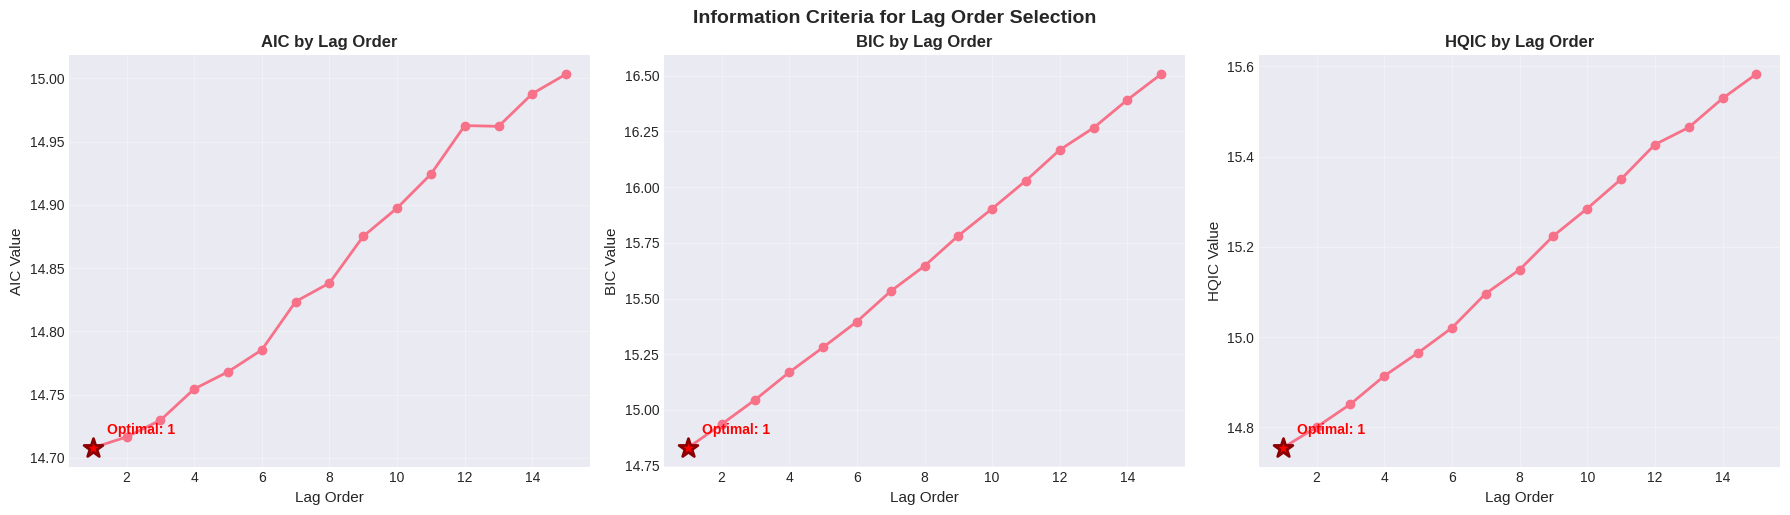

In [ ]:
ic_values = []
for lag in range(1, max_lags + 1):
    try:
        result = model.fit(lag)
        ic_values.append({
            'Lag': lag,
            'AIC': result.aic,
            'BIC': result.bic,
            'HQIC': result.hqic
        })
    except:
        pass

ic_df = pd.DataFrame(ic_values)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, criterion in enumerate(['AIC', 'BIC', 'HQIC']):
    axes[idx].plot(ic_df['Lag'], ic_df[criterion], marker='o', linewidth=2, markersize=6)
    axes[idx].set_xlabel('Lag Order', fontsize=11)
    axes[idx].set_ylabel(f'{criterion} Value', fontsize=11)
    axes[idx].set_title(f'{criterion} by Lag Order', fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

    min_idx = ic_df[criterion].idxmin()
    min_lag = ic_df.loc[min_idx, 'Lag']
    min_val = ic_df.loc[min_idx, criterion]
    axes[idx].scatter([min_lag], [min_val], color='red', s=200, zorder=5,
                     marker='*', edgecolors='darkred', linewidths=2)
    axes[idx].annotate(f'Optimal: {min_lag}', xy=(min_lag, min_val),
                      xytext=(10, 10), textcoords='offset points',
                      fontsize=10, fontweight='bold', color='red')

plt.tight_layout()
plt.suptitle('Information Criteria for Lag Order Selection',
             fontsize=14, fontweight='bold', y=1.02)
plt.show()

## 6. VAR Model Estimation

We'll estimate the VAR model using the optimal lag order selected by BIC.

**VAR(p) Model**:
$$y_t = c + A_1 y_{t-1} + A_2 y_{t-2} + ... + A_p y_{t-p} + \epsilon_t$$

where $y_t$ is a vector of our 6 brand returns at time t.

In [ ]:
var_model = model.fit(selected_lag)

print("\n" + "="*100)
print(f"VAR MODEL ESTIMATION - LAG ORDER: {selected_lag}")
print("="*100)
print(var_model.summary())
print("\n" + "="*100)


VAR MODEL ESTIMATION - LAG ORDER: 1
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 16, Oct, 2025
Time:                     02:30:35
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    14.8294
Nobs:                     763.000    HQIC:                   14.7547
Log likelihood:          -9921.65    FPE:                2.44089e+06
AIC:                      14.7079    Det(Omega_mle):     2.37794e+06
--------------------------------------------------------------------
Results for equation Hermes
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.971163         1.178043            0.824           0.410
L1.Hermes         0.145612         0.055711            2.614           0.009
L1.Kering         0.099180         0.2

In [ ]:
print("\nModel Fit Statistics:")
print(f"  Log-Likelihood: {var_model.llf:.4f}")
print(f"  AIC: {var_model.aic:.4f}")
print(f"  BIC: {var_model.bic:.4f}")
print(f"  HQIC: {var_model.hqic:.4f}")
print(f"  Number of coefficients: {var_model.df_model}")
print(f"  Degrees of freedom (residuals): {var_model.df_resid}")


Model Fit Statistics:
  Log-Likelihood: -9921.6538
  AIC: 14.7079
  BIC: 14.8294
  HQIC: 14.7547
  Number of coefficients: 5
  Degrees of freedom (residuals): 758


### 6.1 Residual Analysis

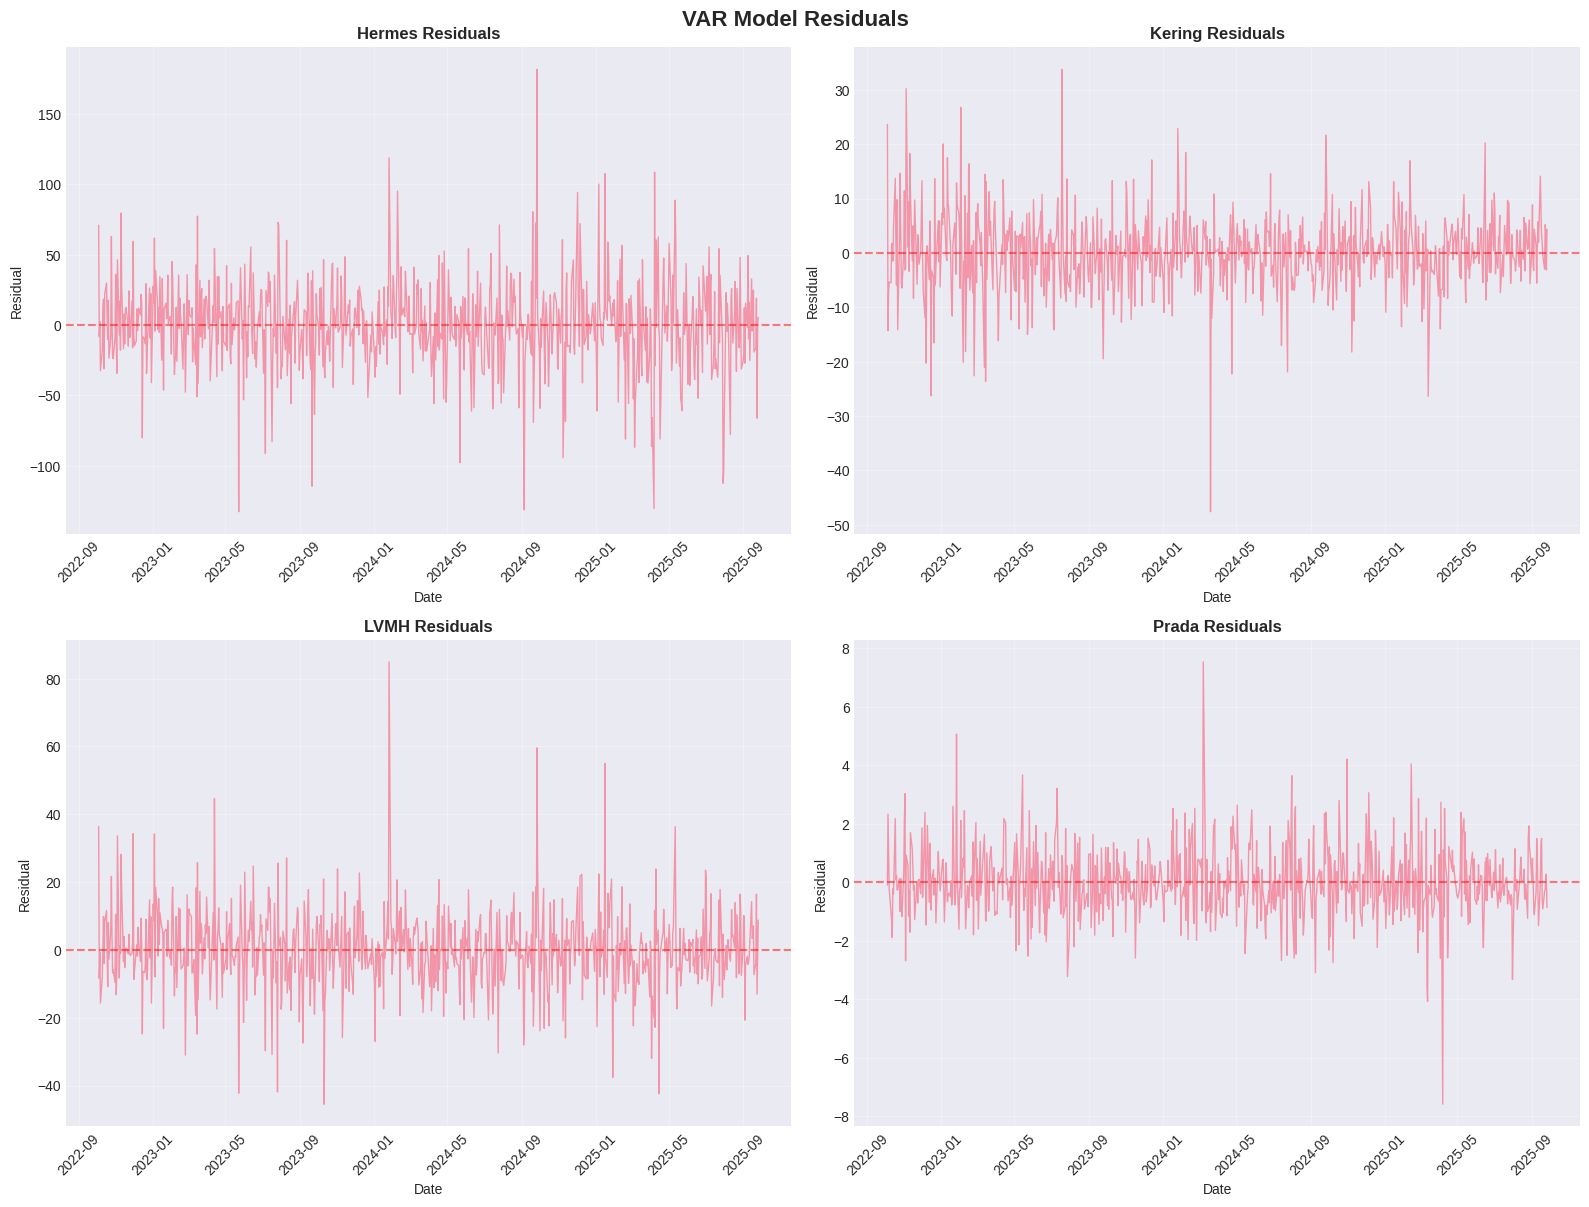

In [ ]:
residuals = var_model.resid

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, brand in enumerate(residuals.columns):
    axes[idx].plot(residuals.index, residuals[brand], linewidth=1, alpha=0.7)
    axes[idx].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    axes[idx].set_title(f'{brand} Residuals', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Residual')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.suptitle('VAR Model Residuals', fontsize=16, fontweight='bold', y=1.002)
plt.show()

## 7. Granger Causality Testing

Granger causality tests whether one time series can predict another.

**Null Hypothesis (H₀)**: Variable X does NOT Granger-cause variable Y

**Alternative Hypothesis (H₁)**: Variable X Granger-causes variable Y

If **p-value < 0.05**, we reject H₀ and conclude X Granger-causes Y.

In [ ]:
max_lag_granger = selected_lag

granger_results = []
brands = var_data.columns.tolist()

print("\n" + "="*100)
print("GRANGER CAUSALITY TESTS (TIME-DOMAIN)")
print("="*100)
print(f"Testing at lag order: {max_lag_granger}")
print("\n")

for cause in brands:
    for effect in brands:
        if cause != effect:
            test_data = var_data[[effect, cause]]

            try:
                gc_result = grangercausalitytests(test_data, max_lag_granger, verbose=False)

                p_value = gc_result[max_lag_granger][0]['ssr_ftest'][1]
                f_stat = gc_result[max_lag_granger][0]['ssr_ftest'][0]

                granger_results.append({
                    'Cause': cause,
                    'Effect': effect,
                    'F-statistic': f_stat,
                    'p-value': p_value,
                    'Granger-Causes': 'Yes' if p_value < 0.05 else 'No',
                    'Significance': '***' if p_value < 0.01 else ('**' if p_value < 0.05 else ('*' if p_value < 0.10 else ''))
                })
            except:
                pass

granger_df = pd.DataFrame(granger_results)
print(granger_df.to_string(index=False))
print("\n" + "="*100)
print("Significance levels: *** p<0.01, ** p<0.05, * p<0.10")
print("="*100)


GRANGER CAUSALITY TESTS (TIME-DOMAIN)
Testing at lag order: 1


 Cause Effect  F-statistic      p-value Granger-Causes Significance
Hermes Kering     0.915433 3.389813e-01             No             
Hermes   LVMH     2.934741 8.710043e-02             No            *
Hermes  Prada    69.325851 3.871282e-16            Yes          ***
Kering Hermes     0.545838 4.602515e-01             No             
Kering   LVMH     0.454998 5.001760e-01             No             
Kering  Prada    48.185228 8.320358e-12            Yes          ***
  LVMH Hermes     4.256153 3.944753e-02            Yes           **
  LVMH Kering     1.445508 2.296246e-01             No             
  LVMH  Prada    62.239245 1.059265e-14            Yes          ***
 Prada Hermes     1.566068 2.111641e-01             No             
 Prada Kering     0.049985 8.231490e-01             No             
 Prada   LVMH     0.837204 3.604879e-01             No             

Significance levels: *** p<0.01, ** p<0.05, * p<0.

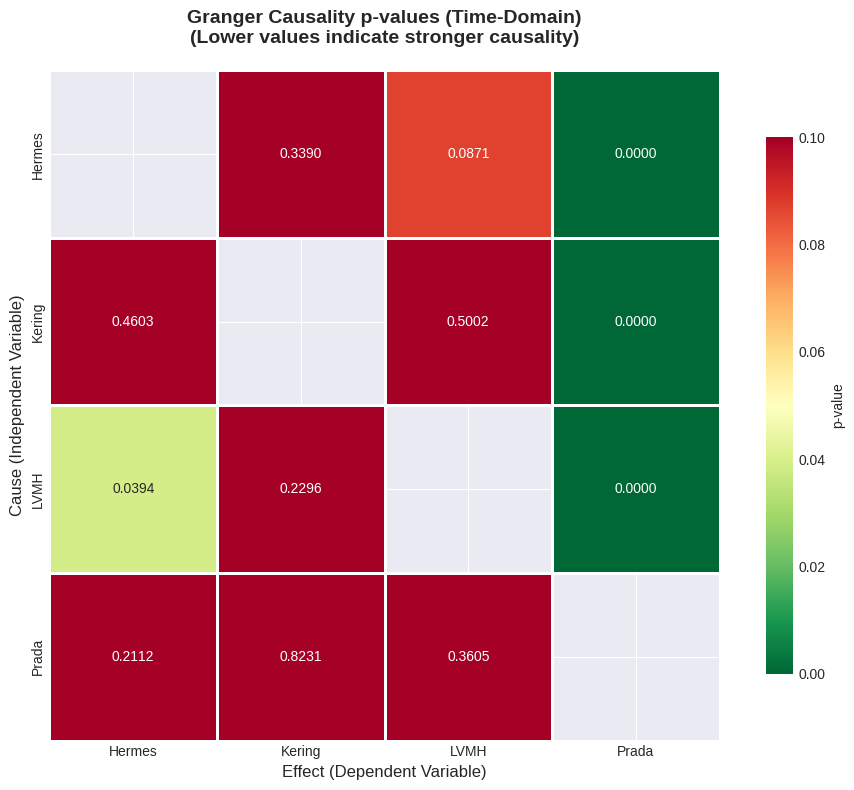


Significant Granger Causality Relationships (p < 0.05): 4

Significant relationships:
  Hermes → Prada (p=0.0000)
  Kering → Prada (p=0.0000)
  LVMH → Hermes (p=0.0394)
  LVMH → Prada (p=0.0000)


In [ ]:
granger_matrix = granger_df.pivot_table(
    index='Cause',
    columns='Effect',
    values='p-value'
)
plt.figure(figsize=(10, 8))
sns.heatmap(granger_matrix, annot=True, fmt='.4f', cmap='RdYlGn_r',
            vmin=0, vmax=0.10, square=True, linewidths=1,
            cbar_kws={"shrink": 0.8, "label": "p-value"})
plt.title('Granger Causality p-values (Time-Domain)\n(Lower values indicate stronger causality)',
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Effect (Dependent Variable)', fontsize=12)
plt.ylabel('Cause (Independent Variable)', fontsize=12)
plt.tight_layout()
plt.show()
significant_causality = granger_df[granger_df['p-value'] < 0.05]
print(f"\nSignificant Granger Causality Relationships (p < 0.05): {len(significant_causality)}")
if len(significant_causality) > 0:
    print("\nSignificant relationships:")
    for _, row in significant_causality.iterrows():
        print(f"  {row['Cause']} → {row['Effect']} (p={row['p-value']:.4f})")

## 8. Bayesian VAR (BVAR) with Minnesota Priors

Bayesian VAR uses prior beliefs to reduce the number of coefficients and improve forecasting performance. The Minnesota prior (Litterman prior) assumes:

1. **Random walk prior**: Variables are likely to follow random walks
2. **Own lags matter more**: Own lags are more important than other variables' lags
3. **Recent lags matter more**: Recent lags are more important than distant lags

This shrinks coefficients toward zero, reducing overfitting.

In [ ]:
class BayesianVAR:
    """
    Bayesian VAR with Minnesota (Litterman) prior
    """
    def __init__(self, lags, lambda1=0.2, lambda2=1.0, lambda3=1.0):
        """
        Parameters:
        -----------
        lags : int
            Number of lags
        lambda1 : float
            Overall tightness (smaller = more shrinkage)
        lambda2 : float
            Cross-variable weight (smaller = more shrinkage of other variables)
        lambda3 : float
            Lag decay (higher = faster decay for distant lags)
        """
        self.lags = lags
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.lambda3 = lambda3

    def fit(self, data):
        self.data = data
        T, k = data.shape
        self.n_vars = k
        self.lags = self.lags
        X = np.ones((T - self.lags, 1))
        for lag in range(1, self.lags + 1):
            X = np.hstack([X, data.values[self.lags - lag:T - lag]])
        n_params = X.shape[1]  # number of coefficients per equation (including intercept)

        coefficients = np.zeros((n_params, k))
        posterior_variance = np.zeros((n_params, n_params, k))
        for i in range(k):
            y_i = data.values[self.lags:, i]
            b_prior = np.zeros(n_params)
            sigma = np.std(data.values, axis=0)
            prior_var = np.zeros(n_params)
            prior_var[0] = 1e6  # loose prior for intercept
            idx = 1
            for lag in range(1, self.lags + 1):
                for j in range(k):
                    if i == j:
                       prior_var[idx] = (self.lambda1 / (lag ** self.lambda3)) ** 2
                    else:
                       prior_var[idx] = ((self.lambda1 * self.lambda2 * sigma[j]) / (lag ** self.lambda3 * sigma[i])) ** 2
                    idx += 1
            V_prior_inv = np.diag(1.0 / prior_var)
            XtX = X.T @ X
            XtY = X.T @ y_i
            V_post_inv = V_prior_inv + XtX
            V_post = np.linalg.inv(V_post_inv)
            b_post = V_post @ (V_prior_inv @ b_prior + XtY)
            coefficients[:, i] = b_post
            posterior_variance[:, :, i] = V_post

        self.coefficients = coefficients
        self.posterior_variance = posterior_variance
        residuals = data.values[self.lags:, :] - X @ coefficients
        self.sigma_u = (residuals.T @ residuals) / (T - self.lags - n_params)
        return self


    def _create_matrices(self, data):
        """
        Create VAR design matrices
        """
        T = len(data)
        Y = data.values[self.lags:]

        X = np.ones((T - self.lags, 1))
        for lag in range(1, self.lags + 1):
            X = np.hstack([X, data.values[self.lags - lag:T - lag]])

        return Y, X

    def _minnesota_prior(self, data):
        """
        Set up Minnesota prior
        """
        n_vars = self.n_vars
        n_coefs = 1 + n_vars * self.lags

        sigma = np.std(data.values, axis=0)

        prior_mean = np.zeros(n_coefs * n_vars)
        prior_variance = np.zeros(n_coefs * n_vars)

        idx = 0
        for i in range(n_vars):
            prior_variance[idx] = 1e6
            idx += 1

            for lag in range(1, self.lags + 1):
                for j in range(n_vars):
                    if i == j:
                        prior_mean[idx] = 0
                        prior_variance[idx] = (self.lambda1 / (lag ** self.lambda3)) ** 2
                    else:
                        prior_mean[idx] = 0
                        prior_variance[idx] = (
                            (self.lambda1 * self.lambda2 * sigma[j]) /
                            (lag ** self.lambda3 * sigma[i])
                        ) ** 2
                    idx += 1

        return prior_mean, prior_variance

print("Bayesian VAR class defined successfully")

Bayesian VAR class defined successfully


In [ ]:
print("Fitting Bayesian VAR with Minnesota priors...")
print(f"\nHyperparameters:")
print(f"  λ1 (overall tightness) = 0.2")
print(f"  λ2 (cross-variable) = 1.0")
print(f"  λ3 (lag decay) = 1.0")
print(f"  Lag order: {selected_lag}\n")

bvar_model = BayesianVAR(lags=selected_lag, lambda1=0.2, lambda2=1.0, lambda3=1.0)
bvar_model.fit(var_data)

print("✓ Bayesian VAR model fitted successfully")
print(f"\nNumber of coefficients: {len(bvar_model.coefficients)}")
print(f"Effective parameters (after shrinkage): ~{np.sum(np.abs(bvar_model.coefficients) > 0.01)}")

Fitting Bayesian VAR with Minnesota priors...

Hyperparameters:
  λ1 (overall tightness) = 0.2
  λ2 (cross-variable) = 1.0
  λ3 (lag decay) = 1.0
  Lag order: 1

✓ Bayesian VAR model fitted successfully

Number of coefficients: 5
Effective parameters (after shrinkage): ~16


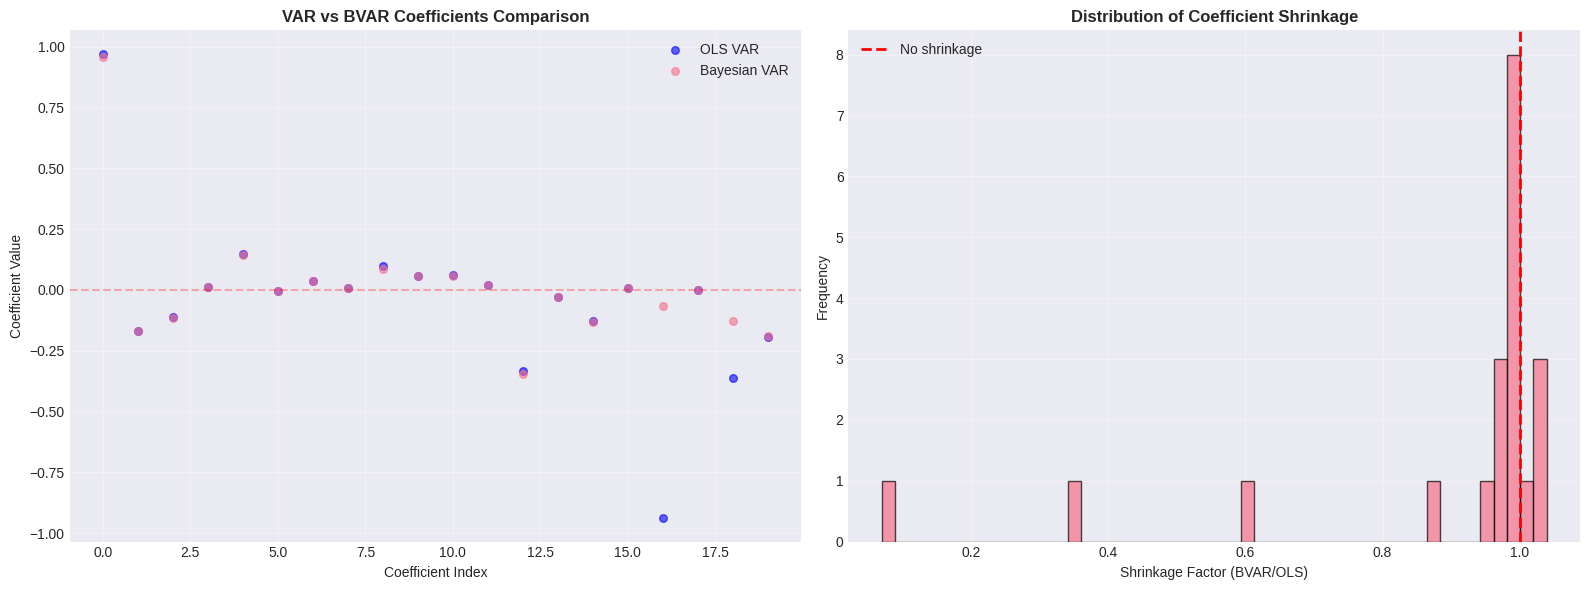


Coefficient Shrinkage Statistics:
  Mean shrinkage factor: 0.893
  Median shrinkage factor: 0.992
  Coefficients shrunk to ~0: 4


In [ ]:
bvar_coefs_flat = bvar_model.coefficients.flatten()
ols_coefs_flat = var_model.params.values.flatten()
min_len = min(len(ols_coefs_flat), len(bvar_coefs_flat))
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].scatter(range(min_len), ols_coefs_flat[:min_len], color='blue', alpha=0.6, label='OLS VAR', s=30)
axes[0].scatter(range(min_len), bvar_coefs_flat[:min_len], alpha=0.6, label='Bayesian VAR', s=30)
axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.3)
axes[0].set_xlabel('Coefficient Index')
axes[0].set_ylabel('Coefficient Value')
axes[0].set_title('VAR vs BVAR Coefficients Comparison', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
shrinkage = np.abs(bvar_coefs_flat[:min_len] / (ols_coefs_flat[:min_len] + 1e-10))
axes[1].hist(shrinkage[np.isfinite(shrinkage)], bins=50, alpha=0.7, edgecolor='black')
axes[1].axvline(x=1, color='red', linestyle='--', label='No shrinkage', linewidth=2)
axes[1].set_xlabel('Shrinkage Factor (BVAR/OLS)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Coefficient Shrinkage', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
print("\nCoefficient Shrinkage Statistics:")
print(f"  Mean shrinkage factor: {np.mean(shrinkage[np.isfinite(shrinkage)]):.3f}")
print(f"  Median shrinkage factor: {np.median(shrinkage[np.isfinite(shrinkage)]):.3f}")
print(f"  Coefficients shrunk to ~0: {np.sum(np.abs(bvar_coefs_flat[:min_len]) < 0.01)}")


## 9. Impulse Response Functions (IRF)

IRF analysis shows how a one-unit shock to one variable affects all variables over time.

We'll compute IRFs for 10 periods ahead using orthogonalized shocks.

In [ ]:
irf_periods = 10
irf = var_model.irf(irf_periods)

print(f"\nIRF computed for {irf_periods} periods ahead")
print(f"Variables: {', '.join(var_data.columns)}")


IRF computed for 10 periods ahead
Variables: Hermes, Kering, LVMH, Prada


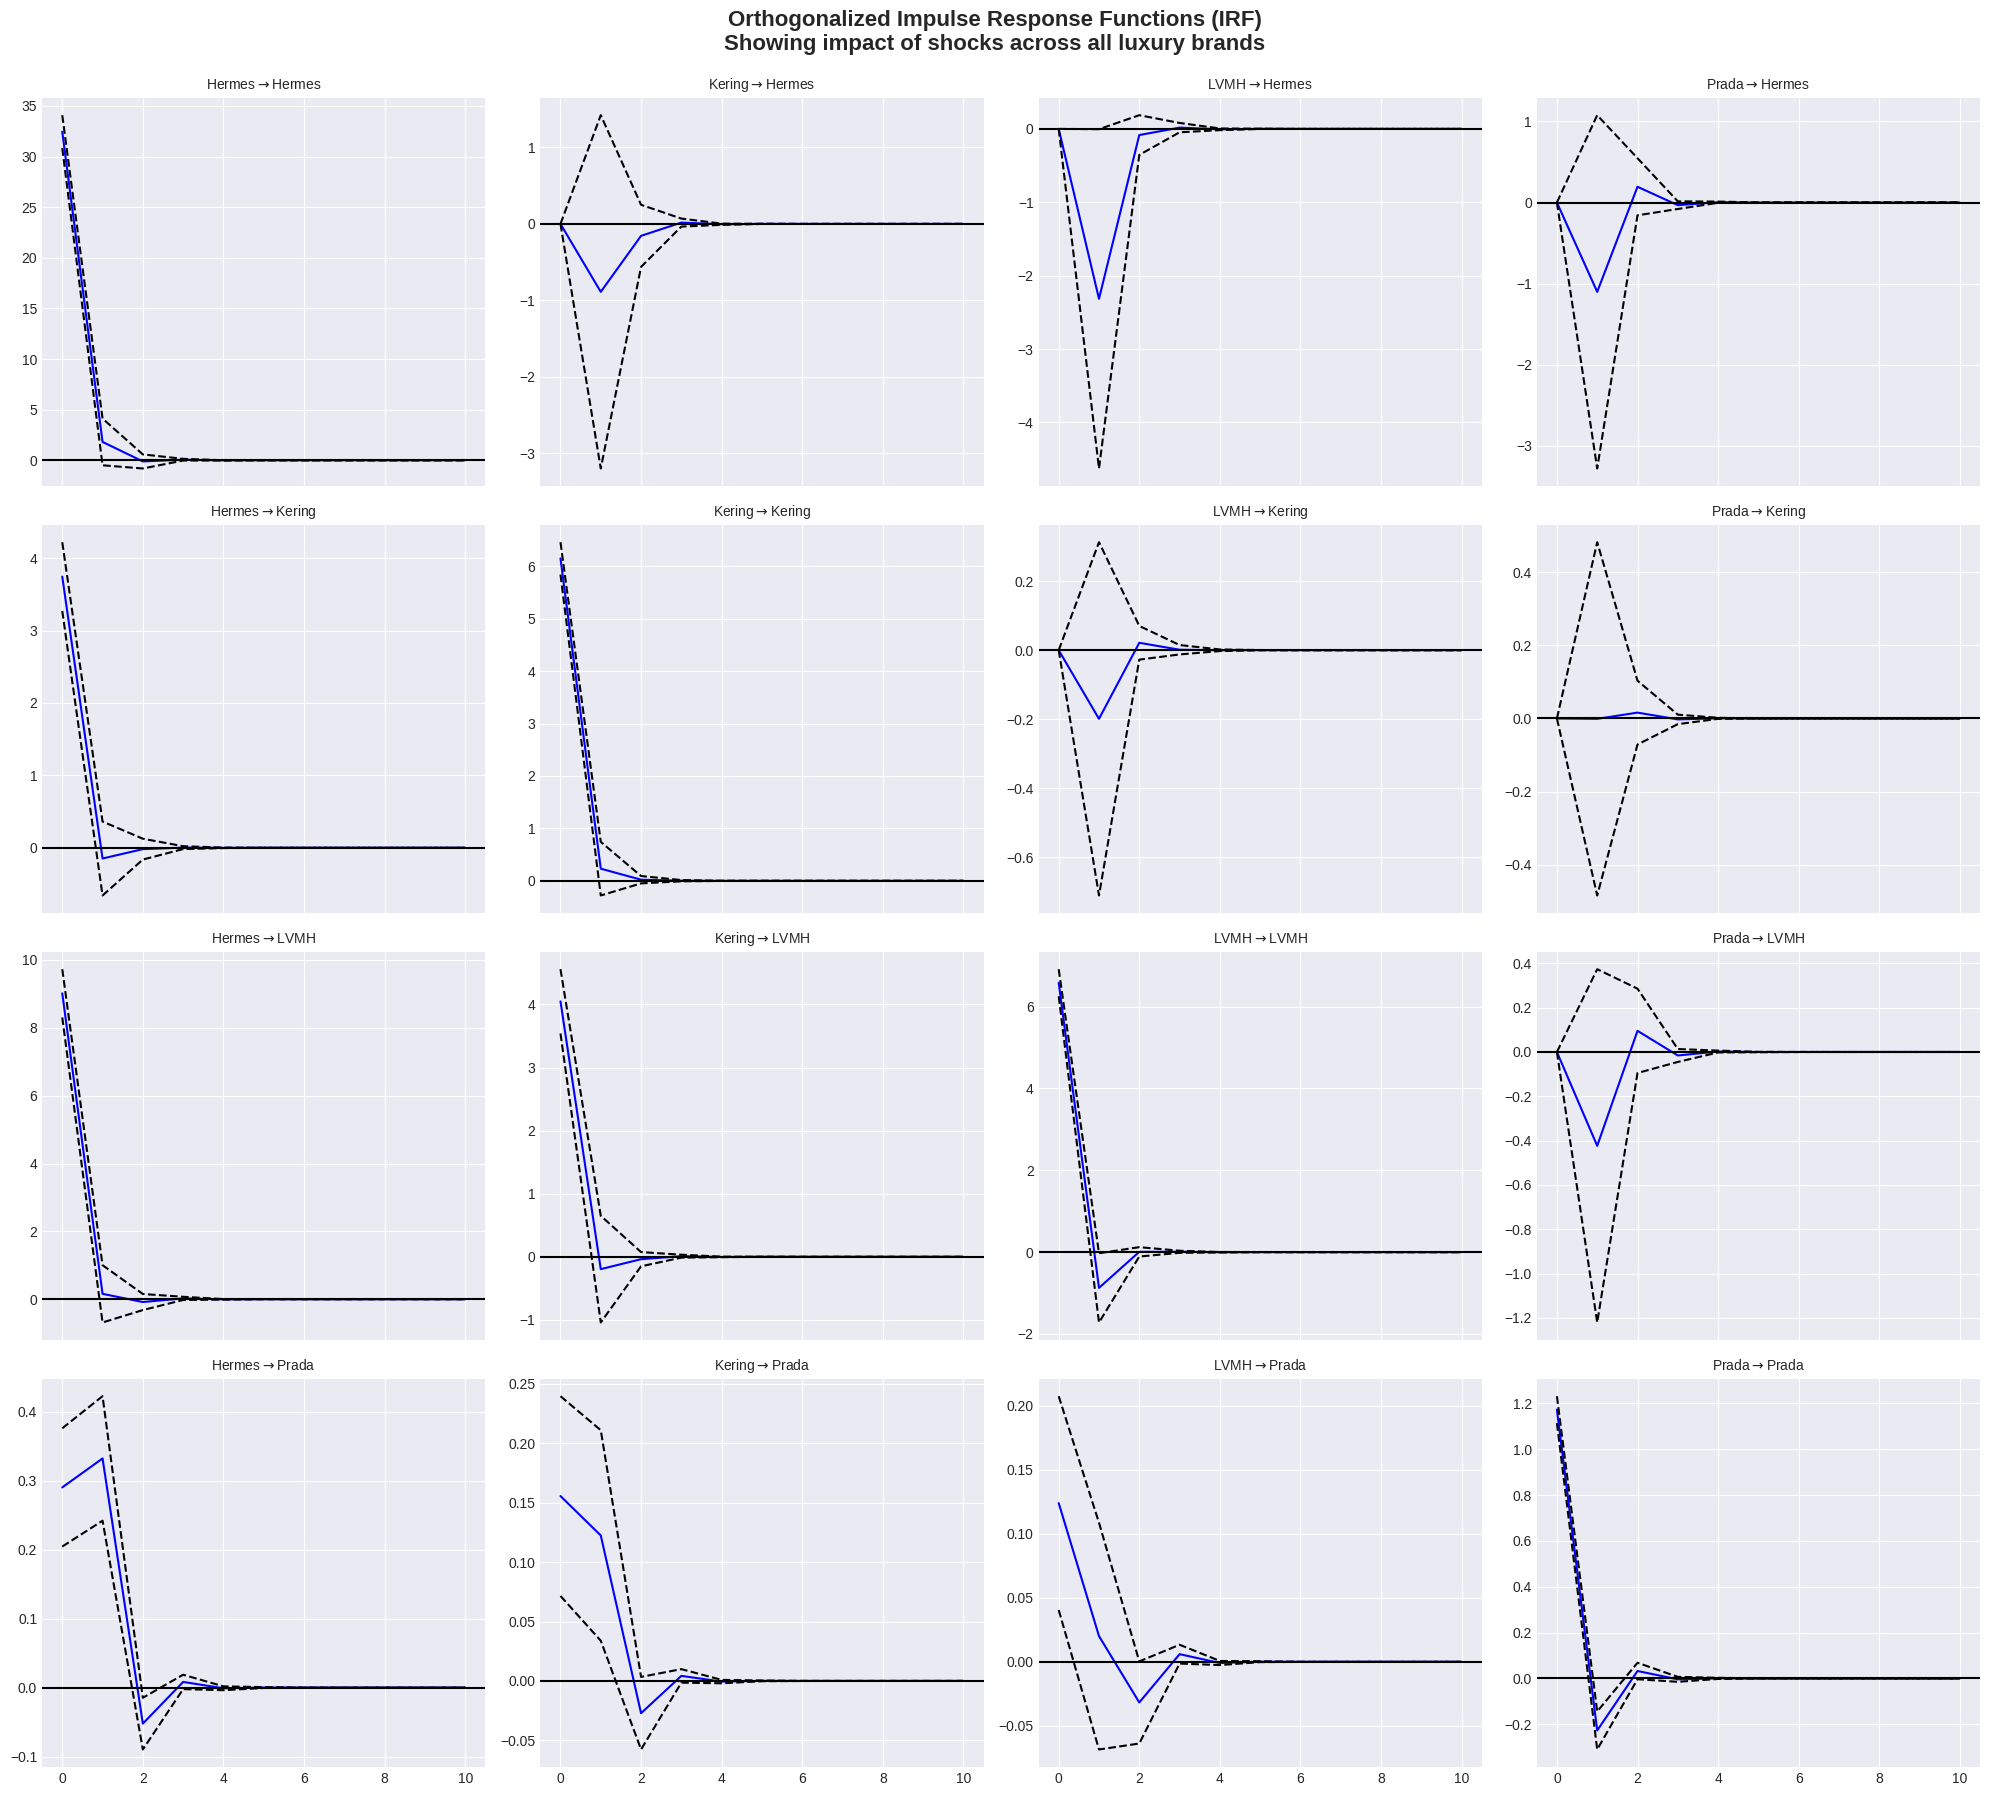

In [ ]:
fig = irf.plot(orth=True, impulse=None, response=None,
               figsize=(20, 18), signif=0.05, subplot_params={'fontsize': 10})
plt.suptitle('Orthogonalized Impulse Response Functions (IRF)\nShowing impact of shocks across all luxury brands',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

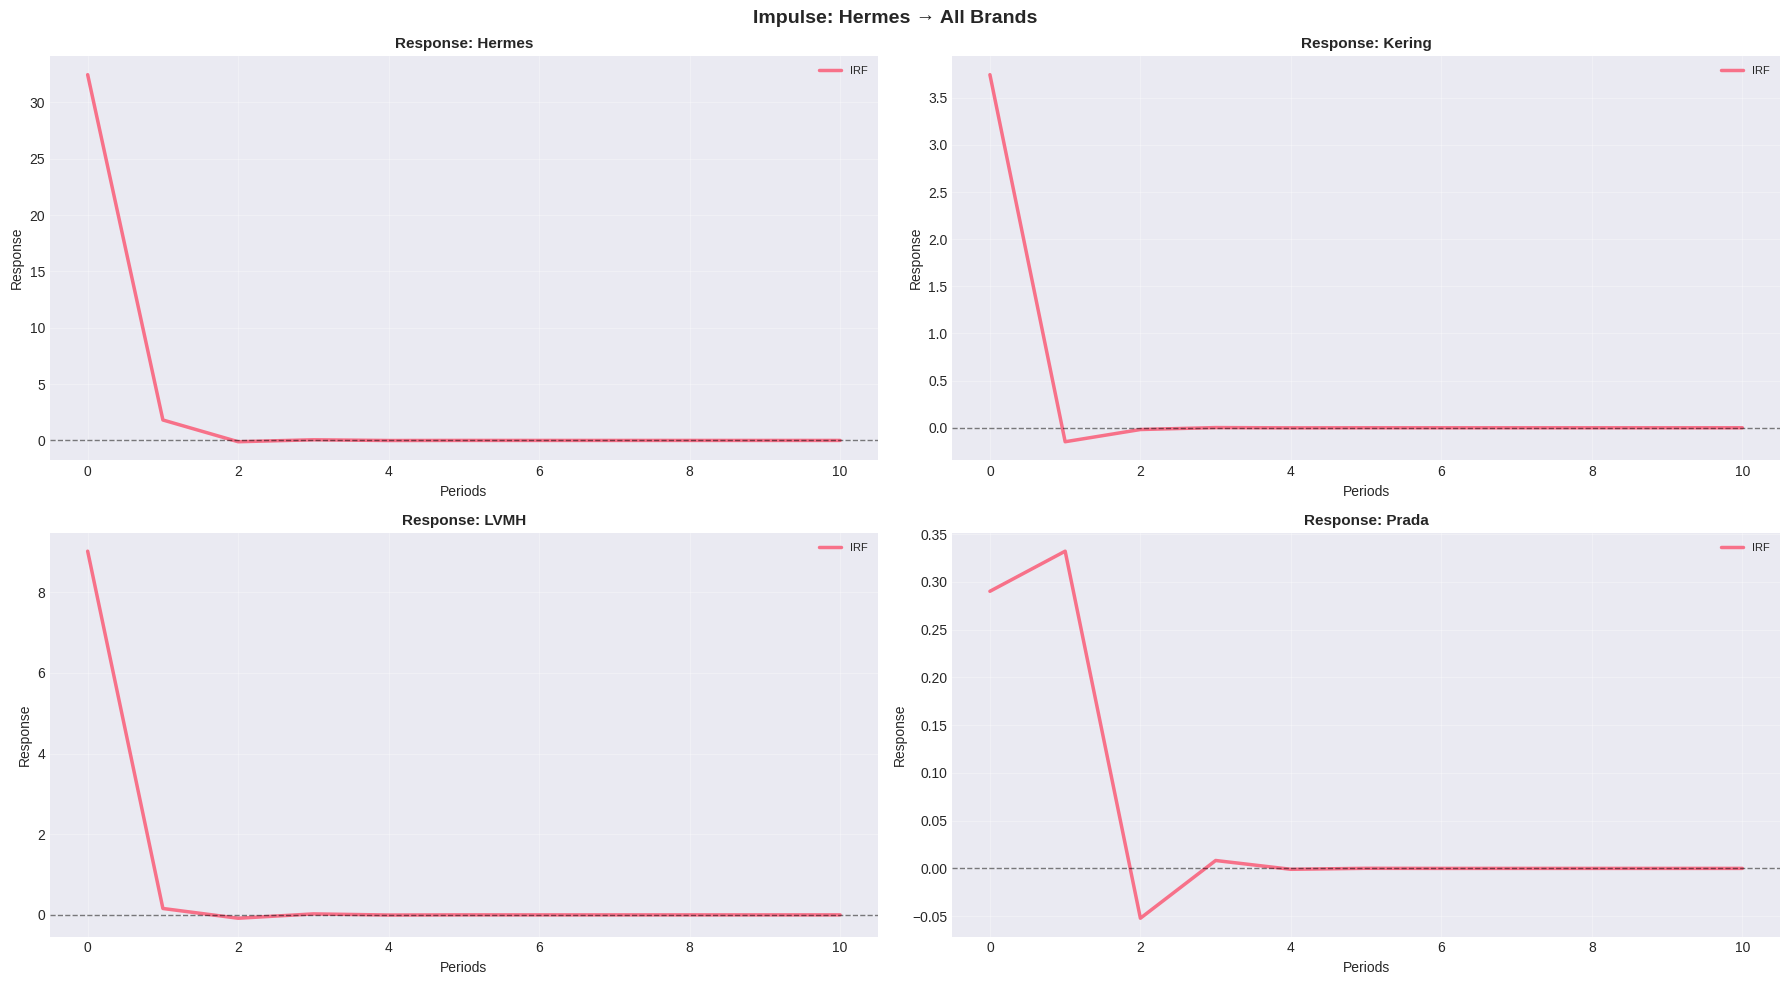

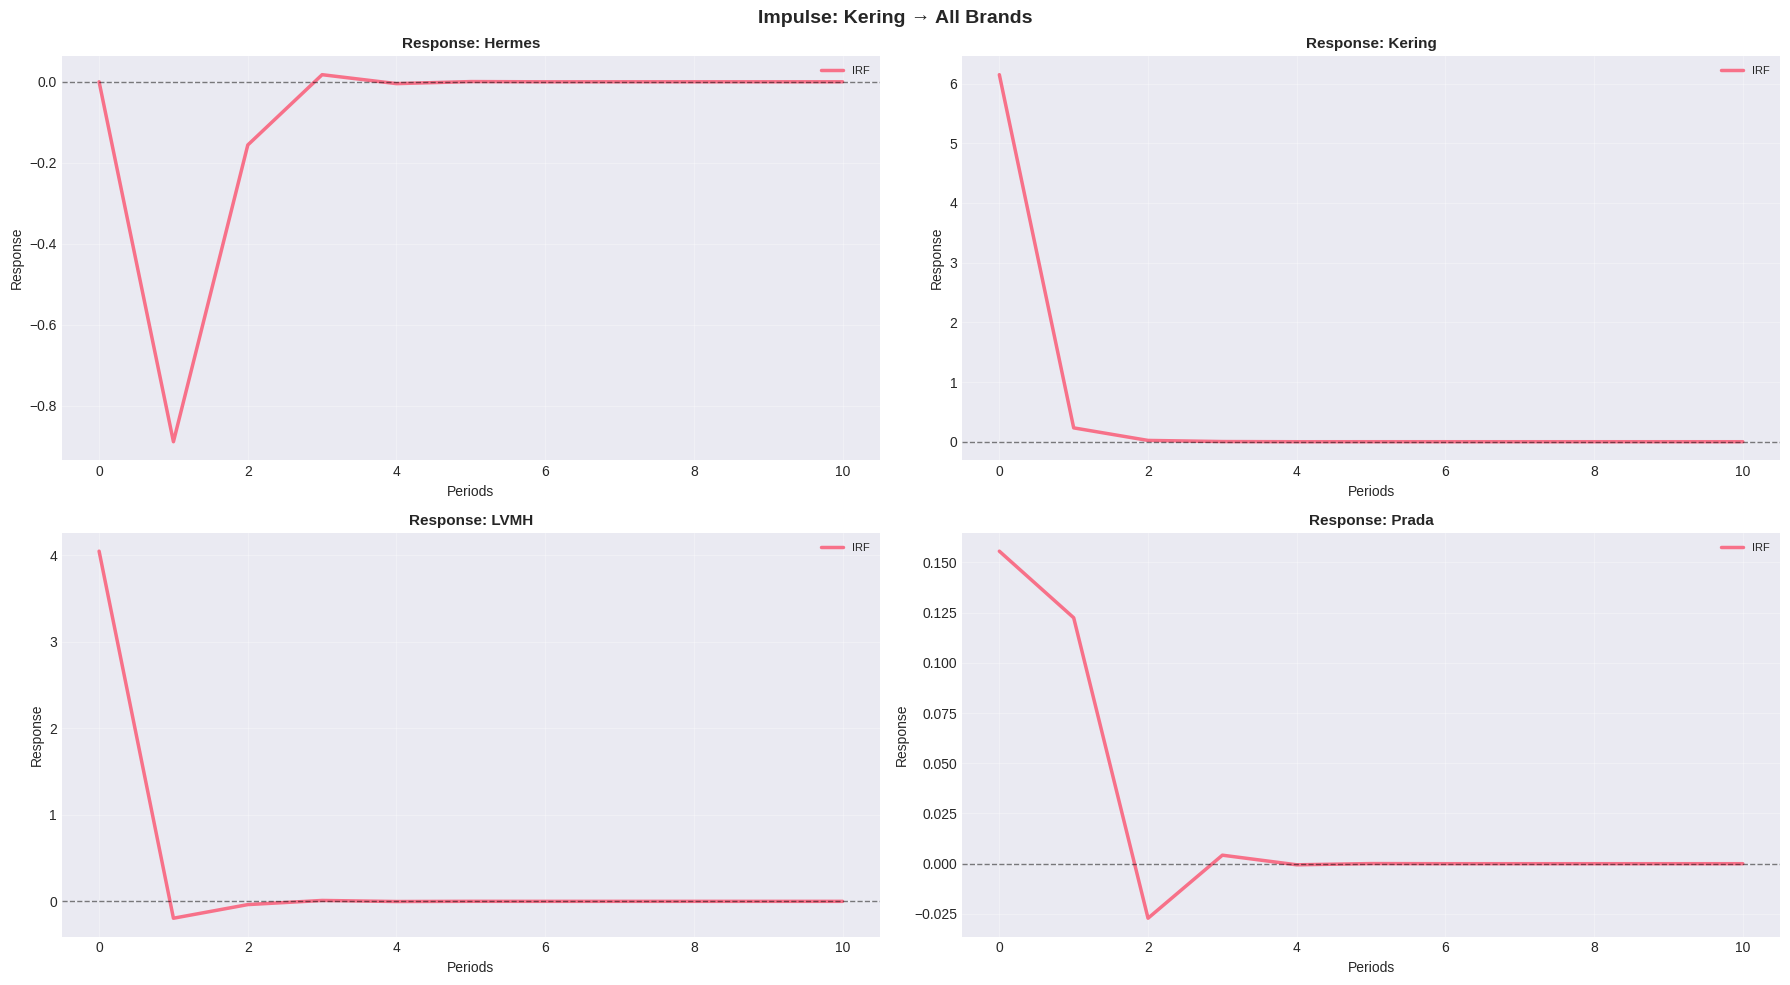

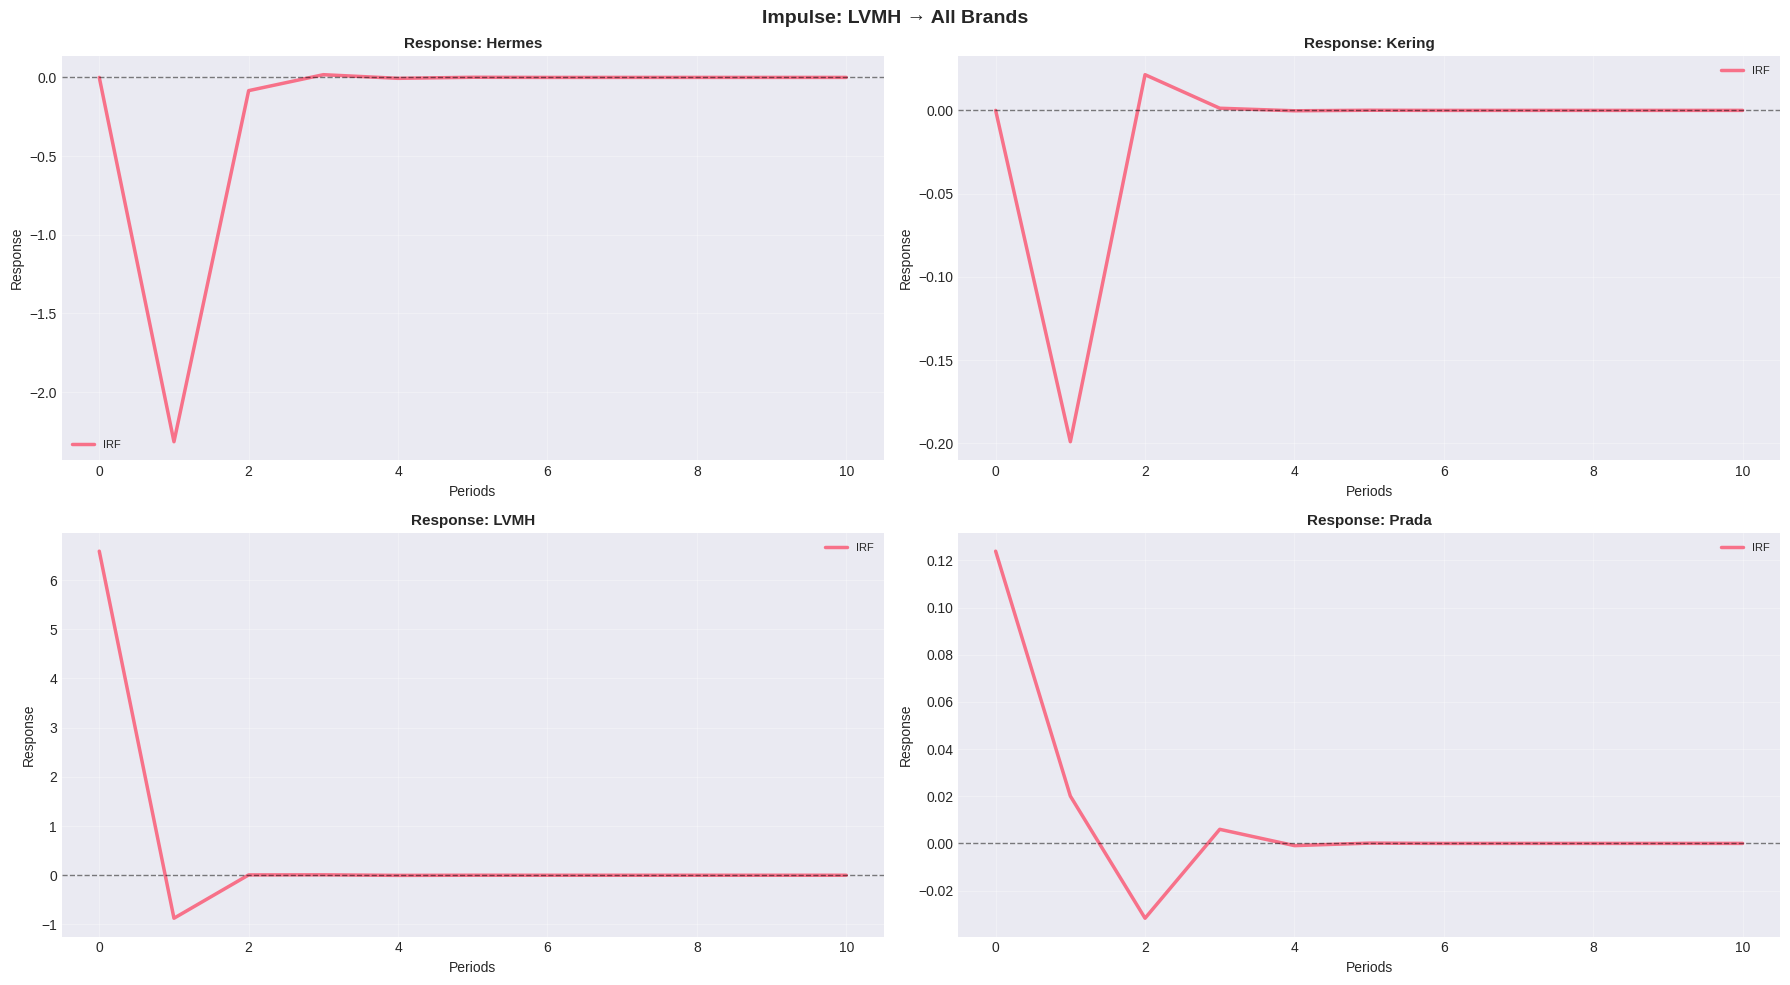

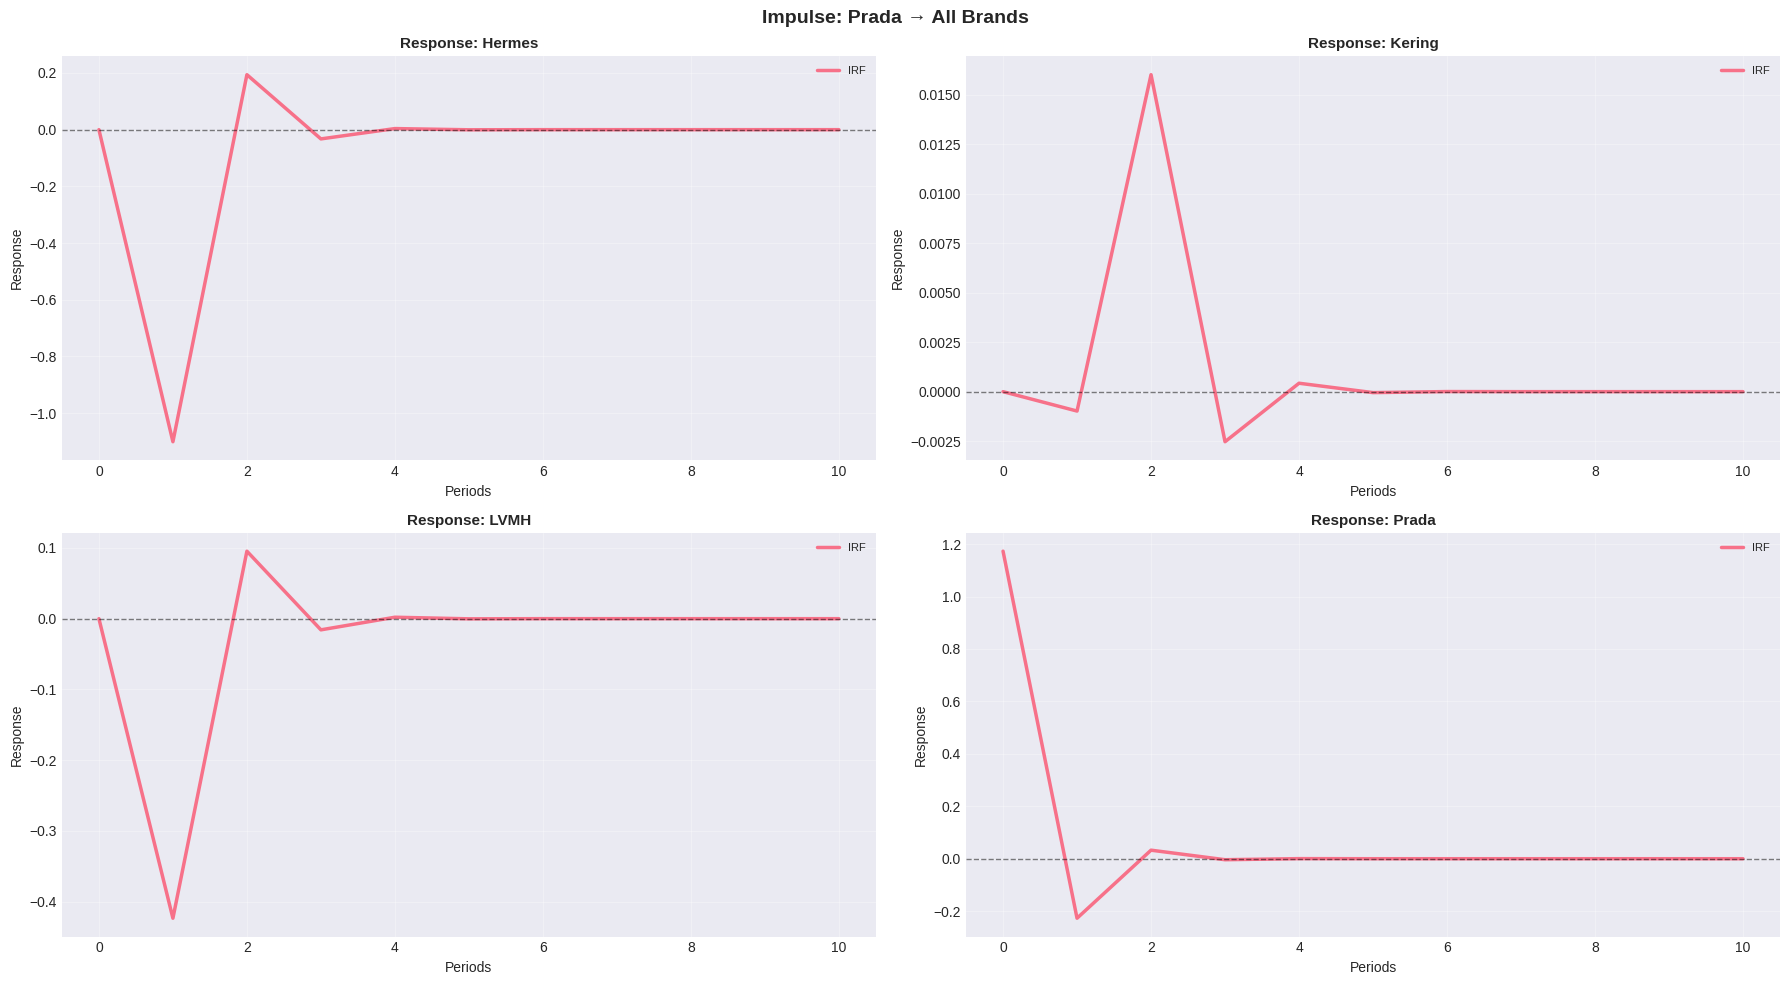

In [ ]:
for impulse_brand in var_data.columns:
    fig, axes = plt.subplots(2, 2, figsize=(18, 10))
    axes = axes.flatten()

    for idx, response_brand in enumerate(var_data.columns):
        irf_values = irf.orth_irfs[:, idx, brands.index(impulse_brand)]

        axes[idx].plot(range(irf_periods + 1), irf_values, linewidth=2.5, label='IRF')
        axes[idx].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        axes[idx].set_title(f'Response: {response_brand}', fontsize=11, fontweight='bold')
        axes[idx].set_xlabel('Periods', fontsize=10)
        axes[idx].set_ylabel('Response', fontsize=10)
        axes[idx].grid(True, alpha=0.3)
        axes[idx].legend(loc='best', fontsize=8)

    plt.suptitle(f'Impulse: {impulse_brand} → All Brands',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

## 10. Forecast Error Variance Decomposition (FEVD)

FEVD shows the proportion of variance in each variable explained by shocks to itself versus shocks to other variables.

This helps us understand the relative importance of each variable in the system.

In [ ]:
fevd_periods = 10
fevd = var_model.fevd(fevd_periods)

print(f"\nFEVD computed for {fevd_periods} periods ahead")


FEVD computed for 10 periods ahead


In [ ]:
for idx, brand in enumerate(var_data.columns):
    print("\n" + "="*100)
    print(f"FORECAST ERROR VARIANCE DECOMPOSITION: {brand}")
    print("="*100)

    # Slice the FEVD: shape = (n_periods, n_vars)
    fevd_slice = fevd.decomp[:, idx, :]

    # Build DataFrame with matching index
    fevd_df = pd.DataFrame(
        fevd_slice,
        columns=var_data.columns,
        index=range(1, fevd_slice.shape[0] + 1)  # 1-based periods
    )
    fevd_df.index.name = 'Period'

    print(fevd_df.to_string())
    print("\nNote: Values show the percentage of forecast error variance explained by each variable")


FORECAST ERROR VARIANCE DECOMPOSITION: Hermes
Brand     Hermes    Kering      LVMH     Prada
Period                                        
1       1.000000  0.000000  0.000000  0.000000
2       0.270577  0.729423  0.000000  0.000000
3       0.576331  0.116243  0.307426  0.000000
4       0.056126  0.016139  0.010242  0.917493

Note: Values show the percentage of forecast error variance explained by each variable

FORECAST ERROR VARIANCE DECOMPOSITION: Kering
Brand     Hermes    Kering      LVMH         Prada
Period                                            
1       0.993081  0.000742  0.005038  1.139281e-03
2       0.270399  0.728839  0.000762  1.850962e-08
3       0.572429  0.115689  0.310620  1.261476e-03
4       0.115968  0.023371  0.009400  8.512606e-01

Note: Values show the percentage of forecast error variance explained by each variable

FORECAST ERROR VARIANCE DECOMPOSITION: LVMH
Brand     Hermes    Kering      LVMH     Prada
Period                                        
1  

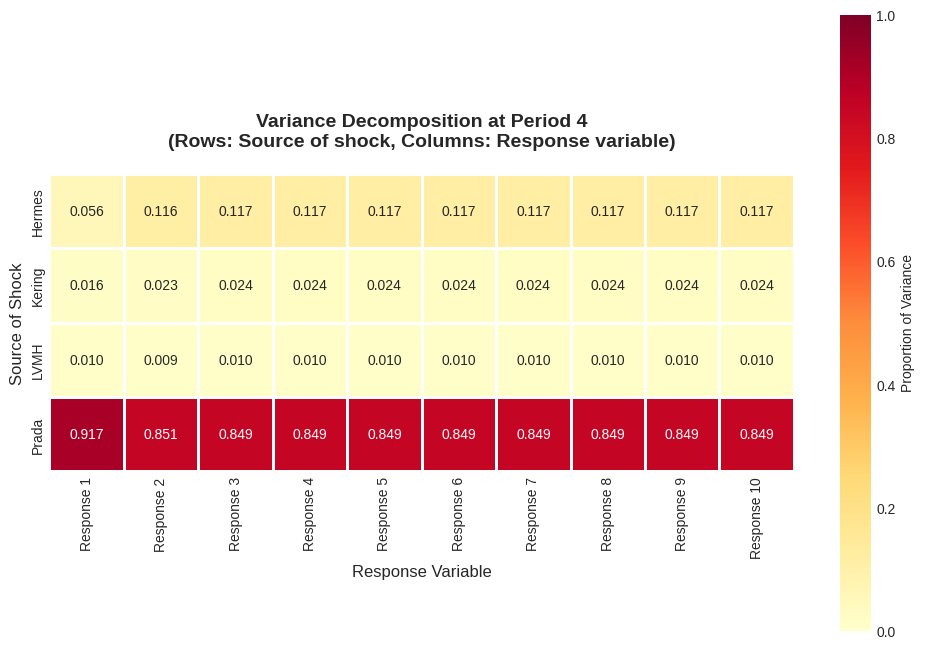


Variance Decomposition at Period 4:
        Response 1  Response 2  Response 3  Response 4  Response 5  \
Brand                                                                
Hermes    0.056126    0.115968    0.117205    0.117237    0.117237   
Kering    0.016139    0.023371    0.023733    0.023741    0.023742   
LVMH      0.010242    0.009400    0.009968    0.009988    0.009989   
Prada     0.917493    0.851261    0.849094    0.849034    0.849033   

        Response 6  Response 7  Response 8  Response 9  Response 10  
Brand                                                                
Hermes    0.117237    0.117237    0.117237    0.117237     0.117237  
Kering    0.023742    0.023742    0.023742    0.023742     0.023742  
LVMH      0.009989    0.009989    0.009989    0.009989     0.009989  
Prada     0.849033    0.849033    0.849033    0.849033     0.849033  


In [ ]:
final_period = 3  # last available period
fevd_slice = fevd.decomp[final_period, :, :]
fevd_final = pd.DataFrame(
    fevd_slice,
    index=[f'Response {i+1}' for i in range(fevd_slice.shape[0])],  # length 10
    columns=var_data.columns  # shocks, length 4
)
plt.figure(figsize=(10, 8))
sns.heatmap(fevd_final.T, annot=True, fmt='.3f', cmap='YlOrRd',
            square=True, linewidths=1, vmin=0, vmax=1,
            cbar_kws={"shrink": 0.8, "label": "Proportion of Variance"})

plt.title(f'Variance Decomposition at Period {final_period+1}\n(Rows: Source of shock, Columns: Response variable)',
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Response Variable', fontsize=12)
plt.ylabel('Source of Shock', fontsize=12)
plt.tight_layout()
plt.show()

# Print FEVD table
print(f"\nVariance Decomposition at Period {final_period+1}:")
print(fevd_final.T)


## 11. State-Space VAR with Kalman Filter

State-space models allow for **latent (hidden) variables** and time-varying parameters. The Kalman filter estimates these unobserved states.

**State-Space Representation**:
- **Observation equation**: $y_t = Z \alpha_t + \epsilon_t$
- **State equation**: $\alpha_{t+1} = T \alpha_t + R \eta_t$

where $\alpha_t$ represents latent states.

In [ ]:
print("Estimating State-Space VAR with Kalman Filter...")
print(f"Lag order: {selected_lag}\n")

try:
    ss_model = VARMAX(var_data, order=(selected_lag, 0), trend='c')
    ss_result = ss_model.fit(disp=False, maxiter=100)

    print("✓ State-Space VAR estimated successfully\n")
    print("Model Summary:")
    print(f"  Log-Likelihood: {ss_result.llf:.4f}")
    print(f"  AIC: {ss_result.aic:.4f}")
    print(f"  BIC: {ss_result.bic:.4f}")

    filtered_states = ss_result.filtered_state
    smoothed_states = ss_result.smoothed_state

    print(f"\n  Filtered states shape: {filtered_states.shape}")
    print(f"  Smoothed states shape: {smoothed_states.shape}")

except Exception as e:
    print(f"⚠ Warning: State-space estimation encountered issues: {e}")
    print("This may be due to model complexity or data characteristics.")
    ss_result = None

Estimating State-Space VAR with Kalman Filter...
Lag order: 1

✓ State-Space VAR estimated successfully

Model Summary:
  Log-Likelihood: -9933.0964
  AIC: 19926.1928
  BIC: 20065.3498

  Filtered states shape: (4, 764)
  Smoothed states shape: (4, 764)


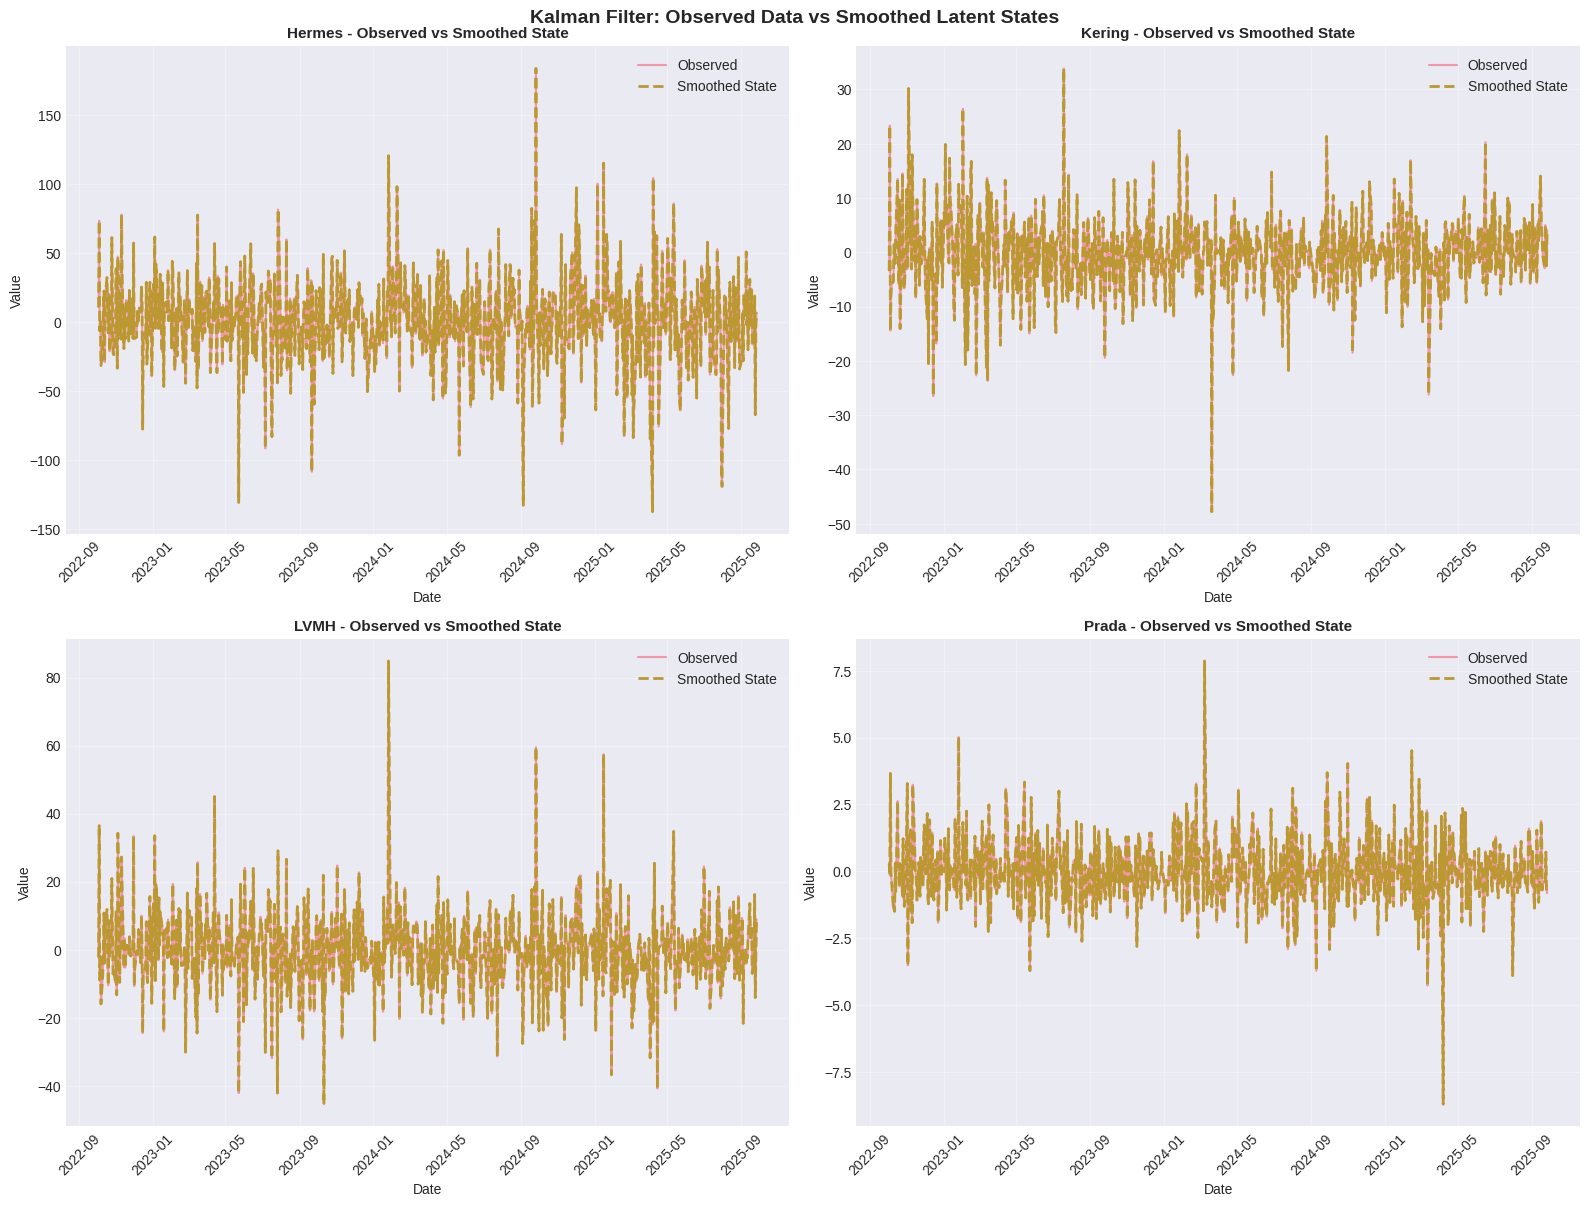


Kalman Filter extracts latent (unobserved) components from the data.
Smoothed states represent the 'true' underlying process after filtering out noise.


In [ ]:
if ss_result is not None:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for idx, brand in enumerate(var_data.columns):
        if idx < smoothed_states.shape[0]:
            axes[idx].plot(var_data.index, var_data[brand],
                          label='Observed', linewidth=1.5, alpha=0.7)
            axes[idx].plot(var_data.index, smoothed_states[idx, :],
                          label='Smoothed State', linewidth=2, linestyle='--')
            axes[idx].set_title(f'{brand} - Observed vs Smoothed State',
                               fontsize=11, fontweight='bold')
            axes[idx].set_xlabel('Date')
            axes[idx].set_ylabel('Value')
            axes[idx].legend()
            axes[idx].grid(True, alpha=0.3)
            axes[idx].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.suptitle('Kalman Filter: Observed Data vs Smoothed Latent States',
                 fontsize=14, fontweight='bold', y=1.002)
    plt.show()

    print("\nKalman Filter extracts latent (unobserved) components from the data.")
    print("Smoothed states represent the 'true' underlying process after filtering out noise.")
else:
    print("State-space visualization skipped due to estimation issues.")

## 12. Non-Linear VAR: Threshold VAR (TVAR)

**Threshold VAR** allows for regime-switching based on a threshold variable. The model switches between different VAR specifications when the threshold variable crosses a certain level.

**TVAR Model**:
$$y_t = \begin{cases}
A_1 y_{t-1} + \epsilon_t & \text{if } z_t \leq \gamma \\
A_2 y_{t-1} + \epsilon_t & \text{if } z_t > \gamma
\end{cases}$$

where $z_t$ is the threshold variable and $\gamma$ is the threshold.

In [ ]:
class ThresholdVAR:
    def __init__(self, threshold_var_idx=0, threshold_percentile=50):
        self.threshold_var_idx = threshold_var_idx
        self.threshold_percentile = threshold_percentile

    def fit(self, data, lags):
        self.data = data
        self.lags = lags

        threshold_series = data.iloc[:, self.threshold_var_idx]
        self.threshold = np.percentile(threshold_series, self.threshold_percentile)

        regime1_mask = threshold_series <= self.threshold
        regime2_mask = threshold_series > self.threshold

        regime1_data = data[regime1_mask]
        regime2_data = data[regime2_mask]

        print(f"\nThreshold value: {self.threshold:.4f}")
        print(f"Regime 1 (low) observations: {len(regime1_data)}")
        print(f"Regime 2 (high) observations: {len(regime2_data)}")

        if len(regime1_data) > lags * 2 and len(regime2_data) > lags * 2:
            self.model_regime1 = VAR(regime1_data)
            self.model_regime2 = VAR(regime2_data)

            self.result_regime1 = self.model_regime1.fit(lags)
            self.result_regime2 = self.model_regime2.fit(lags)

            return self
        else:
            raise ValueError("Not enough observations in one or both regimes")

print("Threshold VAR class defined")

Threshold VAR class defined


In [ ]:
print("Estimating Threshold VAR...")
print(f"Threshold variable: {var_data.columns[0]}")
print(f"Threshold percentile: 50th (median)")

try:
    tvar_model = ThresholdVAR(threshold_var_idx=0, threshold_percentile=50)
    tvar_model.fit(var_data, lags=selected_lag)

    print("\n✓ Threshold VAR estimated successfully")
    print("\nRegime 1 (Low) Model:")
    print(f"  AIC: {tvar_model.result_regime1.aic:.4f}")
    print(f"  BIC: {tvar_model.result_regime1.bic:.4f}")

    print("\nRegime 2 (High) Model:")
    print(f"  AIC: {tvar_model.result_regime2.aic:.4f}")
    print(f"  BIC: {tvar_model.result_regime2.bic:.4f}")

except Exception as e:
    print(f"⚠ Warning: TVAR estimation failed: {e}")
    tvar_model = None

Estimating Threshold VAR...
Threshold variable: Hermes
Threshold percentile: 50th (median)

Threshold value: 0.9936
Regime 1 (low) observations: 382
Regime 2 (high) observations: 382

✓ Threshold VAR estimated successfully

Regime 1 (Low) Model:
  AIC: 14.1788
  BIC: 14.3857

Regime 2 (High) Model:
  AIC: 13.8530
  BIC: 14.0600


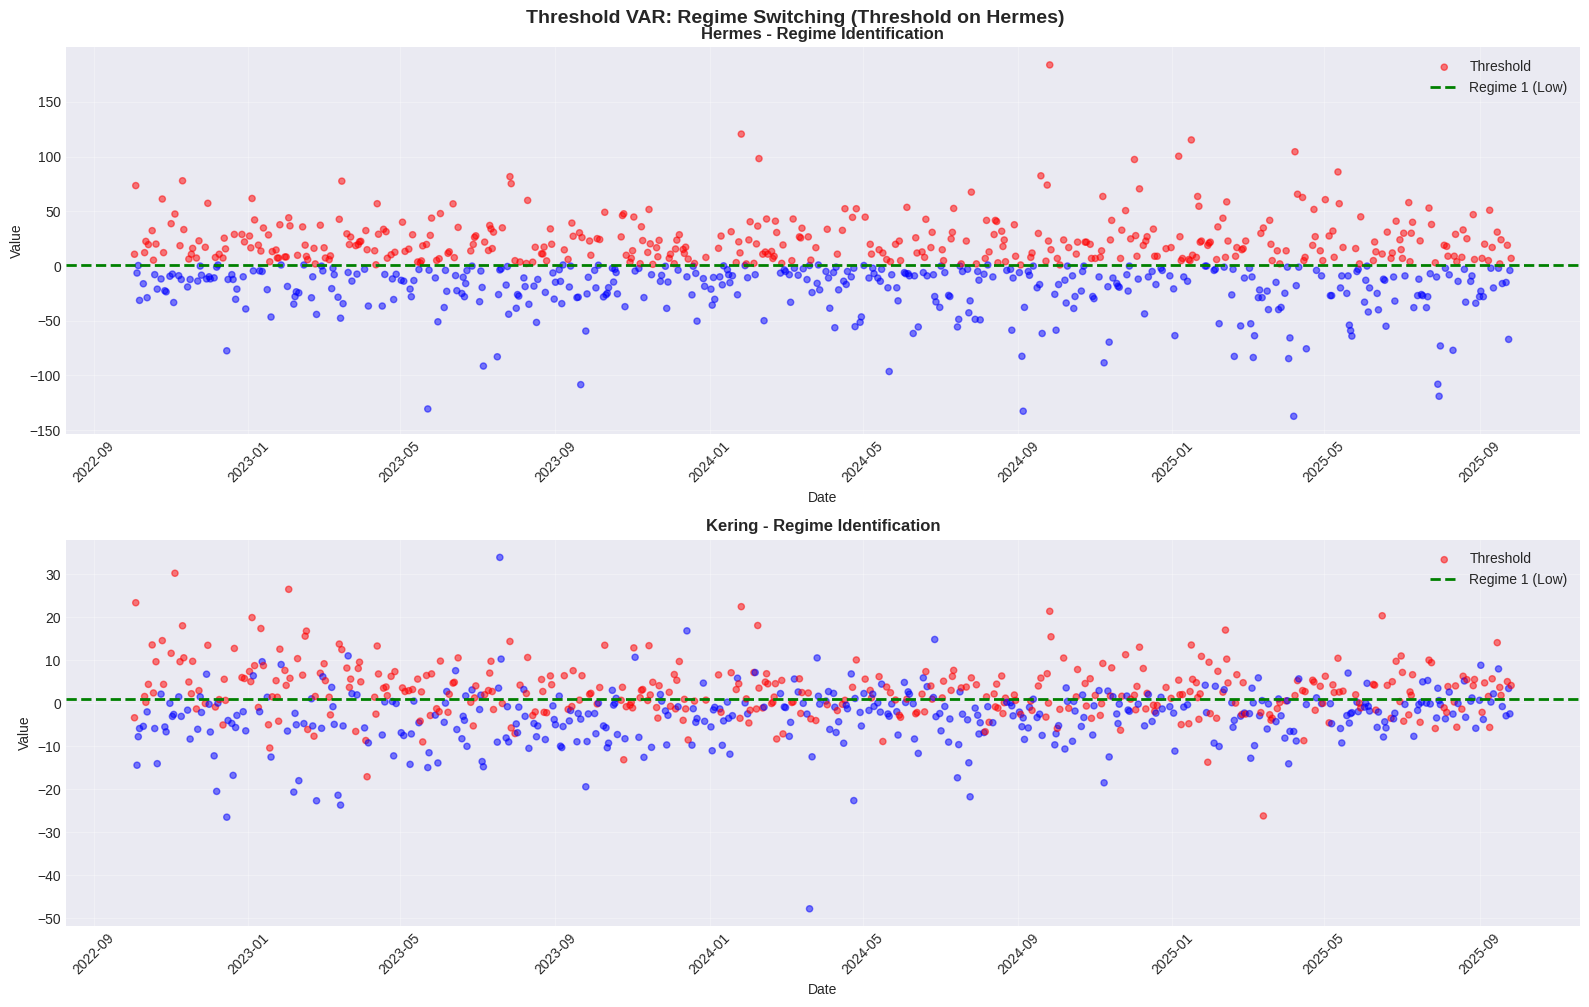


Interpretation:
- Blue points: Low regime (below threshold)
- Red points: High regime (above threshold)
- Different VAR dynamics apply in each regime


In [ ]:
if tvar_model is not None:
    threshold_series = var_data.iloc[:, tvar_model.threshold_var_idx]
    regime_labels = np.where(threshold_series <= tvar_model.threshold,
                             'Regime 1 (Low)', 'Regime 2 (High)')

    fig, axes = plt.subplots(2, 1, figsize=(16, 10))

    for idx, brand in enumerate(var_data.columns[:2]):
        colors = ['blue' if r == 'Regime 1 (Low)' else 'red' for r in regime_labels]
        axes[idx].scatter(var_data.index, var_data[brand], c=colors, alpha=0.5, s=20)
        axes[idx].axhline(y=tvar_model.threshold, color='green',
                         linestyle='--', linewidth=2, label=f'Threshold')
        axes[idx].set_title(f'{brand} - Regime Identification',
                           fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Date')
        axes[idx].set_ylabel('Value')
        axes[idx].legend(['Threshold', 'Regime 1 (Low)', 'Regime 2 (High)'])
        axes[idx].grid(True, alpha=0.3)
        axes[idx].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.suptitle(f'Threshold VAR: Regime Switching (Threshold on {var_data.columns[0]})',
                 fontsize=14, fontweight='bold', y=1.002)
    plt.show()

    print("\nInterpretation:")
    print("- Blue points: Low regime (below threshold)")
    print("- Red points: High regime (above threshold)")
    print("- Different VAR dynamics apply in each regime")
else:
    print("TVAR visualization skipped")

## 13. Markov-Switching VAR (MS-VAR)

**Markov-Switching VAR** allows parameters to switch between regimes according to an unobserved Markov chain. Unlike TVAR, regime transitions are probabilistic.

**MS-VAR Model**:
$$y_t = A_{s_t} y_{t-1} + \epsilon_t$$

where $s_t \in \{1, 2, ..., K\}$ follows a Markov chain with transition probabilities.

In [ ]:
from sklearn.mixture import GaussianMixture

class SimpleMarkovSwitchingVAR:
    """
    Simplified Markov-Switching VAR using GMM for regime classification
    """
    def __init__(self, n_regimes=3):
        self.n_regimes = n_regimes

    def fit(self, data, lags):
        self.data = data
        self.lags = lags

        gmm = GaussianMixture(n_components=self.n_regimes, random_state=42)
        self.regime_probs = gmm.fit_predict(data.values)
        self.regime_prob_smooth = gmm.predict_proba(data.values)

        self.models = []
        self.results = []

        print(f"\nEstimating {self.n_regimes} regime models...")
        for regime in range(self.n_regimes):
            regime_data = data[self.regime_probs == regime]
            print(f"  Regime {regime + 1}: {len(regime_data)} observations")

            if len(regime_data) > lags * 2:
                model = VAR(regime_data)
                result = model.fit(lags)
                self.models.append(model)
                self.results.append(result)
            else:
                print(f"    ⚠ Not enough data for regime {regime + 1}")
                self.models.append(None)
                self.results.append(None)

        transition_matrix = np.zeros((self.n_regimes, self.n_regimes))
        for i in range(len(self.regime_probs) - 1):
            transition_matrix[self.regime_probs[i], self.regime_probs[i+1]] += 1

        transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)
        self.transition_matrix = transition_matrix

        return self

print("Markov-Switching VAR class defined")

Markov-Switching VAR class defined


In [ ]:
print("Estimating Markov-Switching VAR...")
print(f"Number of regimes: 3")

try:
    msvar_model = SimpleMarkovSwitchingVAR(n_regimes=3)
    msvar_model.fit(var_data, lags=selected_lag)

    print("\n✓ Markov-Switching VAR estimated successfully")
    print("\nTransition Probability Matrix:")
    print(pd.DataFrame(msvar_model.transition_matrix,
                      columns=[f'To Regime {i+1}' for i in range(3)],
                      index=[f'From Regime {i+1}' for i in range(3)]))

except Exception as e:
    print(f"⚠ Warning: MS-VAR estimation failed: {e}")
    msvar_model = None

Estimating Markov-Switching VAR...
Number of regimes: 3

Estimating 3 regime models...
  Regime 1: 79 observations
  Regime 2: 42 observations
  Regime 3: 643 observations

✓ Markov-Switching VAR estimated successfully

Transition Probability Matrix:
               To Regime 1  To Regime 2  To Regime 3
From Regime 1     0.177215     0.037975     0.784810
From Regime 2     0.119048     0.047619     0.833333
From Regime 3     0.093458     0.057632     0.848910


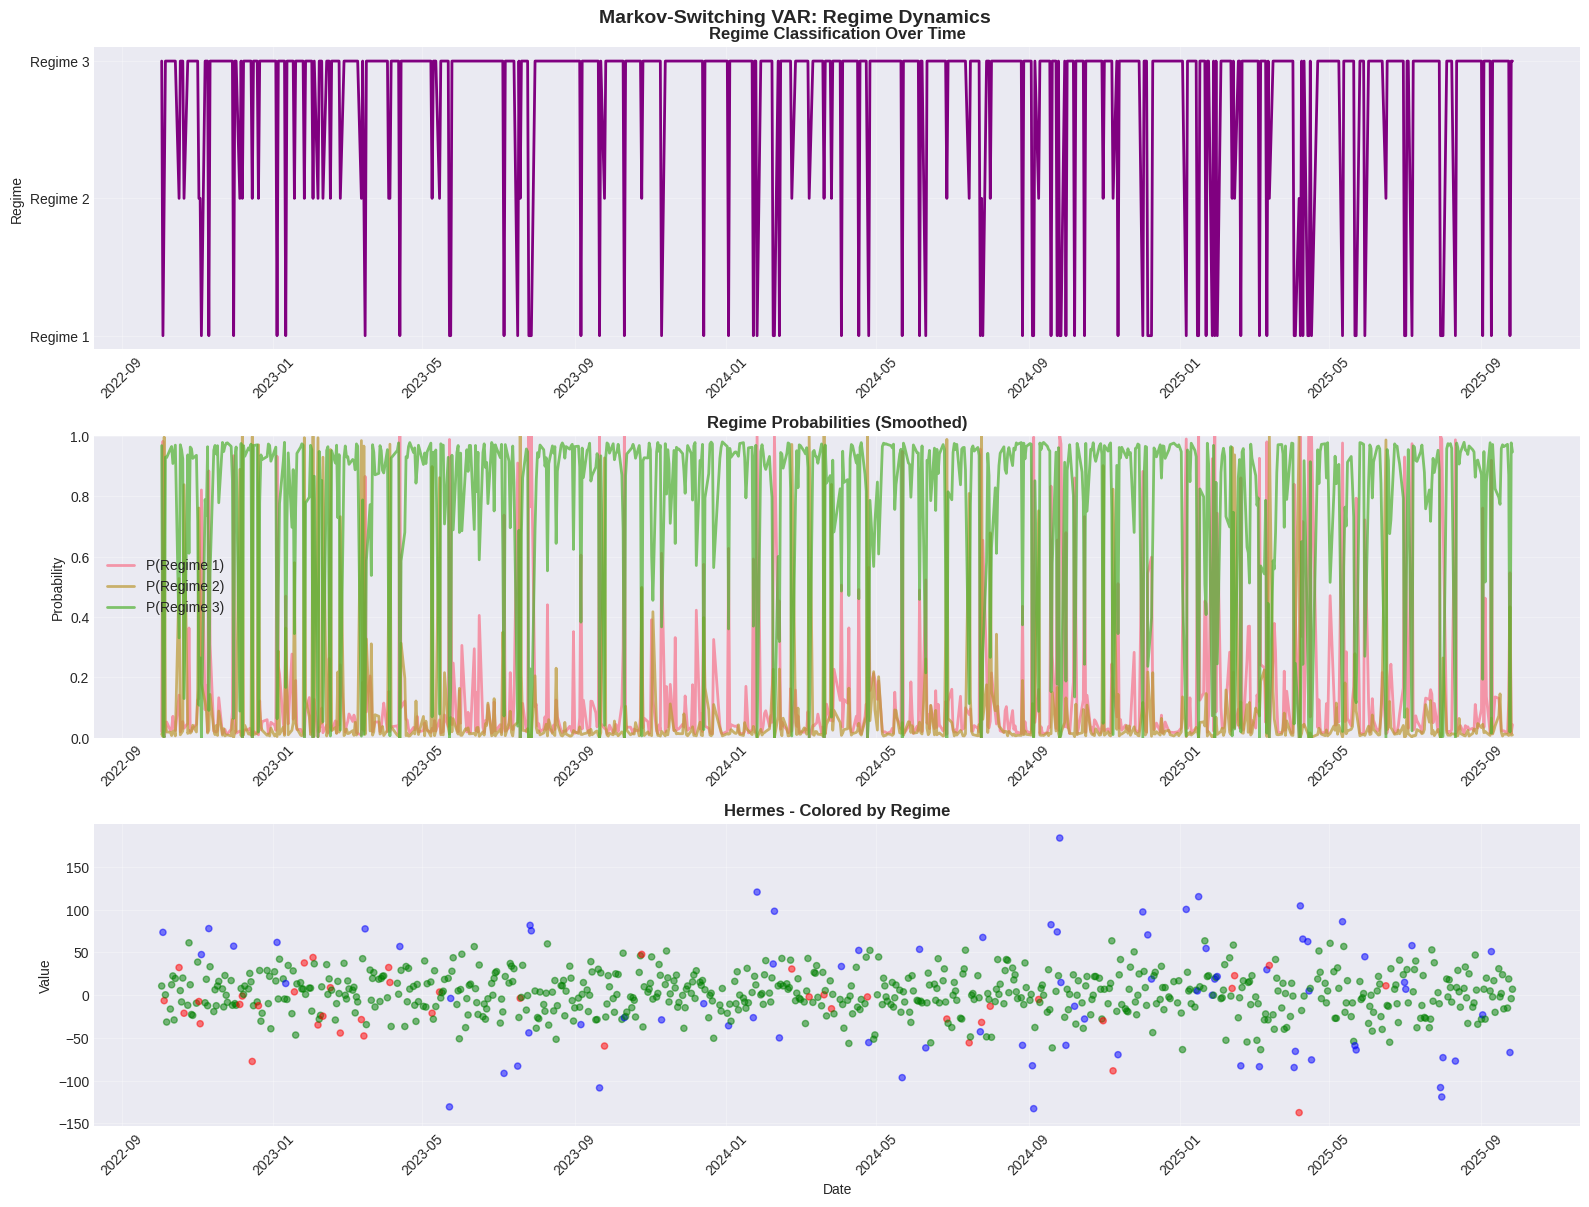


Interpretation:
- Top: Classified regimes over time
- Middle: Smoothed probabilities of being in each regime
- Bottom: Data colored by regime (blue=Regime 1, red=Regime 2, green=Regime 3)


In [ ]:
if msvar_model is not None:
    fig, axes = plt.subplots(3, 1, figsize=(16, 12))

    # --- Top: Regime classification ---
    axes[0].plot(var_data.index, msvar_model.regime_probs,
                 linewidth=2, color='purple')
    axes[0].set_title('Regime Classification Over Time', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Regime')
    axes[0].set_yticks([0, 1, 2])
    axes[0].set_yticklabels(['Regime 1', 'Regime 2', 'Regime 3'])
    axes[0].grid(True, alpha=0.3)
    axes[0].tick_params(axis='x', rotation=45)

    # --- Middle: Smoothed probabilities ---
    for regime in range(3):
        axes[1].plot(var_data.index, msvar_model.regime_prob_smooth[:, regime],
                     label=f'P(Regime {regime + 1})', linewidth=2, alpha=0.7)
    axes[1].set_title('Regime Probabilities (Smoothed)', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Probability')
    axes[1].set_ylim([0, 1])
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].tick_params(axis='x', rotation=45)

    # --- Bottom: Data colored by regime ---
    regime_colors = {0:'blue', 1:'red', 2:'green'}
    colors = [regime_colors[r] for r in msvar_model.regime_probs]
    axes[2].scatter(var_data.index, var_data.iloc[:, 0], c=colors, alpha=0.5, s=20)
    axes[2].set_title(f'{var_data.columns[0]} - Colored by Regime', fontsize=12, fontweight='bold')
    axes[2].set_ylabel('Value')
    axes[2].set_xlabel('Date')
    axes[2].grid(True, alpha=0.3)
    axes[2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.suptitle('Markov-Switching VAR: Regime Dynamics', fontsize=14, fontweight='bold', y=1.002)
    plt.show()

    print("\nInterpretation:")
    print("- Top: Classified regimes over time")
    print("- Middle: Smoothed probabilities of being in each regime")
    print("- Bottom: Data colored by regime (blue=Regime 1, red=Regime 2, green=Regime 3)")
else:
    print("MS-VAR visualization skipped")


## 14. Summary and Conclusions

### Standard VAR Analysis:

1. **Stationarity**: All price series required first differencing to achieve stationarity
2. **Optimal Lag**: BIC criterion selected the optimal lag order
3. **Granger Causality (Time)**: Identified directional relationships between luxury brands
4. **Impulse Responses**: Showed how shocks propagate through the system
5. **Variance Decomposition**: Revealed relative importance of each brand

### Advanced Techniques:

6. **Bayesian VAR**: Reduced overfitting using Minnesota priors, shrinking coefficients
7. **State-Space VAR**: Estimated latent variables using Kalman filter
8. **Threshold VAR**: Identified regime-switching based on threshold levels
9. **Markov-Switching VAR**: Modeled probabilistic regime transitions

### Key Insights:

- **High correlation** among luxury brands suggests common market factors
- **Frequency analysis** reveals whether relationships are short-term or long-term
- **BVAR** provides more stable estimates by incorporating prior beliefs
- **Non-linear models** capture regime changes during market stress/booms

### Applications:

- Portfolio optimization considering regime-dependent correlations
- Risk management with regime-switching volatility
- Forecasting with Bayesian methods for robustness
- Understanding hidden market dynamics through state-space models